# 1 - Execução do arquivo main.py para trazer as bases para o ambiente

In [ ]:
# A execução do script ficará sendo executada porém os prints só serão exibidos após a execução do script.
# O acompanhamento pode ser feito, por exemplo, através da pasta .analysis/data/ onde os arquivos de saída serão gerados.
!python ../main.py

# 2 - Import de biblitecas e define parâmetros necessários

In [1]:
import requests
import gzip
import os
import shutil
import tarfile
import ijson
import pandas as pd
import json
import duckdb
import numpy as np
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
#import sweetviz as sv
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Define opções de exibição de colunas no dataframe
pd.set_option('display.max_columns', None) # opção para exibir todas as colunas
pd.set_option('display.max_colwidth', 50) # opção para exibir o length completo das colunas

## 3 - Cria os dataframes baseado nos arquivos coletados

In [ ]:
con = duckdb.connect()

#alias_orders = './analysis/data/orders/orders_final.parquet' # Seleciona todos os parquets extraidos pelo json #CORRIGIR: ACERTAR O CAMINHO PARA O ARQUIVO PARQUET
alias_orders = './analysis/data/order.json' # Seleciona todos os parquets extraidos pelo json
alias_restaurants = './analysis/data/restaurant.csv' # Seleciona o arquivo restaurants coletado no S3
alias_consumers = './analysis/data/consumer.csv' # Seleciona o arquivo consumer coletado no S3
alias_ab_test = './analysis/data/ab_test_ref.csv' # Seleciona o arquivo ab_test coletado no S3

df_orders = con.execute(f"SELECT * FROM '{alias_orders}' ").df()
df_restaurants = con.execute(f"""SELECT * FROM read_csv_auto('{alias_restaurants}', delim=',', quote='"', escape='\\') """).df()
df_consumers = con.execute(f"""SELECT * FROM read_csv_auto('{alias_consumers}', delim=',', quote='"', escape='\\') """).df()
df_ab_test = con.execute(f"SELECT * FROM '{alias_ab_test}' ").df()

# 4 - Inicia as análises

## 4.1. - Explorar as 04 bases (colunas, preenchimentos, dados vazios, unicos, correlacoes e demais pontos) - EDA Exploratory Data Analysis - utilizando a biblioteca sweetviz

**OBS.: Os reports ficarão salvos na pasta ./analysis/reports_eda**

### 4.1.1. - EDA - Base df_orders

In [9]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3670826 entries, 0 to 3670825
Data columns (total 22 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   cpf                           object 
 1   customer_id                   object 
 2   customer_name                 object 
 3   delivery_address_city         object 
 4   delivery_address_country      object 
 5   delivery_address_district     object 
 6   delivery_address_external_id  object 
 7   delivery_address_latitude     object 
 8   delivery_address_longitude    object 
 9   delivery_address_state        object 
 10  delivery_address_zip_code     object 
 11  items                         object 
 12  merchant_id                   object 
 13  merchant_latitude             object 
 14  merchant_longitude            object 
 15  merchant_timezone             object 
 16  order_created_at              object 
 17  order_id                      object 
 18  order_scheduled       

#### **Ao analisar o conteúdo do método .info() podemos observar que:**

1. **Quantidade de registros:**

   - **Observação:** Há mais de 3.6MM de registros na base. Será necessário analisar o conteúdo das colunas e informações para verificar se há necessidade de limpezas, duplicidades e demais tratamentos.

2. **Tipo das colunas:**

   - **Observação:** Há colunas que precisam ser tratadas com alteração do tipo e demais formatações - colunas como `cpf`, `order_created_at`, `delivery_address_latitude`, `delivery_address_longitude` dentre outras.

In [ ]:
# Utilizando o sweetviz para gerar o report detalhado das descritivas de cada coluna
#report_orders = sv.analyze(df_orders) #linha comentada para otimizar tempo - relatório já gerado na pasta .analysis/reports_eda

                                             |          | [  0%]   00:00 -> (? left)

In [ ]:
# Salvando o arquivo no formato html
#report_orders.show_html() #linha comentada para otimizar tempo - relatório já gerado na pasta .analysis/reports_eda

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


#### **Ao analisar o conteudo do report podemos observar que:**

1. **Há poucas colunas com dados faltantes:**

   - **Coluna:** `customer_id`  
     **Quantidade:** 8.505 valores nulos  
     **Observação:** Menos de 1% do total de registros na tabela.

   - **Coluna:** `order_scheduled_date`  
     **Quantidade:** 3.6MM valores nulos  
     **Observação:** Mais do que 99% do total de registros na tabela - porém não é algo que indica um erro, apenas indica que é o percentual de pedidos que não tiveram agendamento de entrega.

2. **Distribuição dos países de entrega dos pedidos:**

   - **Coluna:** `delivery_address_country`   
     **Observação:** 100% dos pedidos foram feitos para entrega no Brasil.

3. **Distribuição dos estados de entrega dos pedidos:**

   - **Coluna:** `delivery_address_state`   
     **Observação:** A maioria dos pedidos ficaram concentrados nos estados de São Paulo (41%) e Rio de Janeiro (21%), ou seja, maior concentração na região Centro-Oeste do país. Demais estados ficaram com faixas entre 1 a 5%.

4. **Valores dos pedidos:**

   - **Coluna:** `order_total_amount`   
     **Observação:** Os pedidos em geral somaram R$ 351.7 MM -  ticket médio geral dos pedidos foi de aproximadamente R$ 47,90 - valor mínimo de pedido foi de R$ 0,00 e valor máximo de R$ 138.750,90 - esse valor máximo deve ser investigado para entender o que foi pedido e se foi um erro ou questão a ser analisada, assim como demais valores fora do padrão.

5. **Distribuição das plataformas de origem (dispostivios) que foram efetuados os pedidos:**

   - **Coluna:** `origin_platform`   
     **Observação:** A maioria dos pedidos foram solicitados por dispositivos IOS (44%) e ANDRIOD (40%), seguido por DESKTOP (15%) e WINDOWS_PHONE (< 1%).

6. **Agendamento de pedidos:**

   - A maioria dos pedidos efetuados (> 99%) não tiveram agendamento de entrega. Ou seja, foram pedidos que foram solicitados para entrega imediata.

#### Tratamento de colunas
Vamos fazer o tratamento do formato das colunas para que sejam mais aderentes nas necessidades de análise de acordo com o seu contexto.

In [10]:
df_orders.head()

,cpf,customer_id,customer_name,delivery_address_city,delivery_address_country,delivery_address_district,delivery_address_external_id,delivery_address_latitude,delivery_address_longitude,delivery_address_state,delivery_address_zip_code,items,merchant_id,merchant_latitude,merchant_longitude,merchant_timezone,order_created_at,order_id,order_scheduled,order_total_amount,origin_platform,order_scheduled_date
0,80532101763,7ba88a68bb2a3504c6bd37a707af57a0b8d6e110a551c7...,GUSTAVO,FRANCA,BR,JARDIM ESPRAIADO,6736655,-47.39,-20.55,SP,14403,"[{""name"": ""Parmegiana de Filé de Frango (2 pes...",a992a079a651e699d9149423761df2427c0e3af0a2a1b5...,-47.39,-20.55,America/Sao_Paulo,2019-01-17T22:50:06.000Z,33e0612d62e5eb42aba15b58413137e441fbe906de2feb...,False,46.0,ANDROID,None
1,43352103961,078acecdcf7fa89d356bfa349f14a8219db1ee161ce28a...,MICHELLE,SANTOS,BR,CAMPO GRANDE,8759216,-46.34,-23.96,SP,11070,"[{""name"": ""Filé Mignon à Cubana"", ""addition"": ...",5152f28ee0518b8803ccf0a4096eb2ff8b81e9491861c9...,-46.34,-23.96,America/Sao_Paulo,2019-01-17T17:51:26.000Z,148c4353a2952f3fe7973547283265eb22b575fb712ed2...,False,104.5,ANDROID,None
2,38650991217,0e38a3237b5946e8ab2367b4f1a3ae6e77f1e215bc760c...,VICTOR,GUARULHOS,BR,JARDIM ROSSI,8765930,-46.53,-23.44,SP,71304,"[{""name"": ""GRANDE 2 SABORES"", ""addition"": {""va...",b6096419455c35d06105a5ef0d25c51f9dd40e1e99ac33...,-46.53,-23.44,America/Sao_Paulo,2019-01-17T22:53:47.000Z,c37e495a91b498bb7b70a9e09ac115d0cdd443f152dc11...,False,35.0,IOS,None
3,63579726866,cab1a004b7206d07910092c515a79834fea0a03d7d9054...,ANNIE,SAO PAULO,BR,PARQUE SAO JORGE,7834087,-46.57,-23.53,SP,30870,"[{""name"": ""CALABRESA"", ""addition"": {""value"": ""...",082bfdcdf6ccdc343e3c4d25ee376b5b6ca7e96ad8b04e...,-46.57,-23.53,America/Sao_Paulo,2019-01-17T23:56:53.000Z,b4df94142d21354611247da9ca94f870c09b93989b531a...,False,40.8,IOS,None
4,90617788806,aa7edf5b166b8c843aec3b96dc561222888734f3879123...,DANIEL,VITORIA,BR,JARDIM CAMBURI,7211683,-40.27,-20.25,ES,29090,"[{""name"": ""GRANDE (35CM) 8 PDÇ 2 SABORES"", ""ad...",d7adb764bac29ccb77fb8f746ffbd531bf05ec30a7e130...,-40.27,-20.25,America/Sao_Paulo,2019-01-17T23:40:53.000Z,4ff64b33b272c1886df21b63272220af6a82d1667dba70...,False,48.5,ANDROID,None


In [11]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3670826 entries, 0 to 3670825
Data columns (total 22 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   cpf                           object 
 1   customer_id                   object 
 2   customer_name                 object 
 3   delivery_address_city         object 
 4   delivery_address_country      object 
 5   delivery_address_district     object 
 6   delivery_address_external_id  object 
 7   delivery_address_latitude     object 
 8   delivery_address_longitude    object 
 9   delivery_address_state        object 
 10  delivery_address_zip_code     object 
 11  items                         object 
 12  merchant_id                   object 
 13  merchant_latitude             object 
 14  merchant_longitude            object 
 15  merchant_timezone             object 
 16  order_created_at              object 
 17  order_id                      object 
 18  order_scheduled       

In [12]:
df_orders['cpf']                          = df_orders['cpf'].astype('int64')
df_orders['delivery_address_external_id'] = df_orders['delivery_address_external_id'].astype('int64')
df_orders['delivery_address_latitude']    = df_orders['delivery_address_latitude'].astype('float64')
df_orders['delivery_address_longitude']   = df_orders['delivery_address_longitude'].astype('float64')
df_orders['delivery_address_zip_code']    = df_orders['delivery_address_zip_code'].astype('int64')
df_orders['merchant_latitude']            = df_orders['merchant_latitude'].astype('float64')
df_orders['merchant_longitude']           = df_orders['merchant_longitude'].astype('float64')
df_orders['order_created_at']             = pd.to_datetime(df_orders['order_created_at'])
df_orders['order_scheduled_date']         = pd.to_datetime(df_orders['order_scheduled_date'])

In [13]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3670826 entries, 0 to 3670825
Data columns (total 22 columns):
 #   Column                        Dtype              
---  ------                        -----              
 0   cpf                           int64              
 1   customer_id                   object             
 2   customer_name                 object             
 3   delivery_address_city         object             
 4   delivery_address_country      object             
 5   delivery_address_district     object             
 6   delivery_address_external_id  int64              
 7   delivery_address_latitude     float64            
 8   delivery_address_longitude    float64            
 9   delivery_address_state        object             
 10  delivery_address_zip_code     int64              
 11  items                         object             
 12  merchant_id                   object             
 13  merchant_latitude             float64            
 14  me

Dados formatados - podemos seguir com as análises prévias

#### Análises Prévias

##### Pedidos com valores muito grandes

Há casos onde temos pedidos cujo valor ultrapassa R$ 100.000 - vamos analisar as características dele.

In [14]:
df_orders[df_orders['order_total_amount'] >= 100000]

,cpf,customer_id,customer_name,delivery_address_city,delivery_address_country,delivery_address_district,delivery_address_external_id,delivery_address_latitude,delivery_address_longitude,delivery_address_state,delivery_address_zip_code,items,merchant_id,merchant_latitude,merchant_longitude,merchant_timezone,order_created_at,order_id,order_scheduled,order_total_amount,origin_platform,order_scheduled_date
2122299,18632426798,361e229dbc1b985e1aacb3e70384782a05d77ad6db53e7...,LUANA,ITAJAI,BR,SAO VICENTE,9485267,-48.69,-26.9,SC,88309,"[{""name"": ""PENNE À MODA DO CHEF"", ""addition"": ...",4c8fcc42e9b434baef6b0518e525c5eae6afa0150f0150...,-48.69,-26.9,America/Sao_Paulo,2019-01-27 18:52:47+00:00,12d3e51072948bc1f089e9a9f38ae97a28e140cd88dfd4...,False,138750.9,ANDROID,NaT
3361672,79697576423,361e229dbc1b985e1aacb3e70384782a05d77ad6db53e7...,LUANA,ITAJAI,BR,SAO VICENTE,9485267,-48.69,-26.9,SC,88309,"[{""name"": ""PENNE À MODA DO CHEF"", ""addition"": ...",4c8fcc42e9b434baef6b0518e525c5eae6afa0150f0150...,-48.69,-26.9,America/Sao_Paulo,2018-12-28 18:52:47+00:00,12d3e51072948bc1f089e9a9f38ae97a28e140cd88dfd4...,False,138750.9,ANDROID,NaT


O mesmo customer_id com CPFs diferentes tem 2 compras com o mesmo order_id em datas diferentes - uma em 28/12/2018 e a outra em 27/01/2019.

customer_id com CPFs diferentes pode ser um problema de base para limpeza e tratamento ou investigação.

In [15]:
qtd_pedidos_duplicados = df_orders['order_id'].value_counts().reset_index().query('count >= 2').shape[0]
qtd_pedidos_total = df_orders['order_id'].value_counts().reset_index().shape[0]

print(f"Quantidade de pedidos duplicados (order_id >= 2): {qtd_pedidos_duplicados} ({round(((qtd_pedidos_duplicados / qtd_pedidos_total) * 100), 2)} %)")

Quantidade de pedidos duplicados (order_id >= 2): 1237852 (50.88 %)


In [16]:
df_orders[df_orders['order_id'] == 'ebbac51abe615cd8c7d3d8b9c339e333173d2802f16c55181a57f473b42a1115']

,cpf,customer_id,customer_name,delivery_address_city,delivery_address_country,delivery_address_district,delivery_address_external_id,delivery_address_latitude,delivery_address_longitude,delivery_address_state,delivery_address_zip_code,items,merchant_id,merchant_latitude,merchant_longitude,merchant_timezone,order_created_at,order_id,order_scheduled,order_total_amount,origin_platform,order_scheduled_date
2432972,1571993914,b8e0b53e6cc7baa79ebabe7a6f00cc24b02a9651d5d4d9...,MANUELA,OSASCO,BR,VELOSO,8000949,-46.82,-23.57,SP,61500,"[{""name"": ""GuaraViton"", ""addition"": {""value"": ...",cc069acc31e1d24beea6d4284cf0662ec0b1821dc50123...,-46.82,-23.57,America/Sao_Paulo,2019-01-04 17:03:39+00:00,ebbac51abe615cd8c7d3d8b9c339e333173d2802f16c55...,False,12.0,ANDROID,NaT
3670256,78673963586,b8e0b53e6cc7baa79ebabe7a6f00cc24b02a9651d5d4d9...,MANUELA,OSASCO,BR,VELOSO,8000949,-46.82,-23.57,SP,61500,"[{""name"": ""GuaraViton"", ""addition"": {""value"": ...",cc069acc31e1d24beea6d4284cf0662ec0b1821dc50123...,-46.82,-23.57,America/Sao_Paulo,2018-12-05 17:03:39+00:00,ebbac51abe615cd8c7d3d8b9c339e333173d2802f16c55...,False,12.0,ANDROID,NaT


In [17]:
df_orders[df_orders['order_id'] == 'cd04d56b51a975e6b86d63fac08b2bc4d96ac0a9ce72b4769a517aa02476de88']

,cpf,customer_id,customer_name,delivery_address_city,delivery_address_country,delivery_address_district,delivery_address_external_id,delivery_address_latitude,delivery_address_longitude,delivery_address_state,delivery_address_zip_code,items,merchant_id,merchant_latitude,merchant_longitude,merchant_timezone,order_created_at,order_id,order_scheduled,order_total_amount,origin_platform,order_scheduled_date
2432970,87265236936,bba7a80756f9ccdb79125766036fd824901d387e7bb541...,ANTONIO,RIO DE JANEIRO,BR,RECREIO DOS BANDEIRANTES,8953769,-43.46,-23.02,RJ,22795,"[{""name"": ""20 HOTS + 20 FILADELFIAS + 15 URAMA...",3feaa1a34a340c41fc1c97113f2cbe7cd017fb87987623...,-43.46,-23.02,America/Sao_Paulo,2019-01-04 14:44:41+00:00,cd04d56b51a975e6b86d63fac08b2bc4d96ac0a9ce72b4...,False,64.1,ANDROID,NaT
3670254,2261714139,bba7a80756f9ccdb79125766036fd824901d387e7bb541...,ANTONIO,RIO DE JANEIRO,BR,RECREIO DOS BANDEIRANTES,8953769,-43.46,-23.02,RJ,22795,"[{""name"": ""20 HOTS + 20 FILADELFIAS + 15 URAMA...",3feaa1a34a340c41fc1c97113f2cbe7cd017fb87987623...,-43.46,-23.02,America/Sao_Paulo,2018-12-05 14:44:41+00:00,cd04d56b51a975e6b86d63fac08b2bc4d96ac0a9ce72b4...,False,64.1,ANDROID,NaT


Temos um vasto número (1.237.852) de pedidos (order_id) que foram feitos mais de uma vez... como parece ser um problema de base, será feita a limpeza dos dados repetidos e considerado manter em base o pedido de data mais antiga apenas.

In [18]:
columns_to_consider = [
    'customer_id',
    'customer_name',
    'delivery_address_external_id',
    'items',
    'merchant_id',
    'order_id',
    'order_total_amount'
]

qtd_registros_df_orders = df_orders.shape[0]
qtd_colunas_df_orders = df_orders.shape[1]
print(f"DataFrame original possui {qtd_registros_df_orders} registros e {qtd_colunas_df_orders} colunas")

# Ordenar o DataFrame pela data de criação do pedido (mais antiga primeiro)
df_orders = df_orders.sort_values(by='order_created_at', ascending=True)

# Removendo duplicados, mantendo o primeiro (que agora é o mais antigo devido à ordenação)
df_orders = df_orders.drop_duplicates(subset=columns_to_consider, keep='first')

qtd_registros_df_orders_new = df_orders.shape[0]
qtd_colunas_df_orders_new = df_orders.shape[1]
print(f"DataFrame após remover duplicados possui {qtd_registros_df_orders_new} registros e {qtd_colunas_df_orders_new} colunas")

print(f"{qtd_registros_df_orders - qtd_registros_df_orders_new} registros foram removidos do DataFrame")

DataFrame original possui 3670826 registros e 22 colunas
DataFrame após remover duplicados possui 2432974 registros e 22 colunas
1237852 registros foram removidos do DataFrame


In [19]:
df_orders.order_id.value_counts()

,count
order_id,
fbff2657f7f1acd96f07ab9405cd89f6c3072f4b9c44079485bbb0410ba333d5,1
d86e1e9206ba828ba622d4bf42027af8addc9ec7a2b11dddd256e00a6795320a,1
7f3c5cfdd855e98aab262bc3078a3651e0f0786b6190f5ff2425996853a7336e,1
afe9d6d1b5d34d86315ae384e5fad6b7d76ffd29e671dc1b6fd31ca4e0ec57d9,1
02eb442c1349a12cb01ef6e96e582203ba7e2775f73dd9f790de70a085cec055,1
...,...
65753df045fab80f7719f20e97bbd9ee3af6668722848761204509218520561d,1
ee2b642c2283b666bfb722b1e31765efb25eeb24827a0ae0e338a6dad9c64013,1
93f4c53c63d08f55b279572efe1e2aa9b2d26f6f2e44cb14dde425d82af15718,1


In [20]:
df_orders[df_orders['order_id'] == 'ebbac51abe615cd8c7d3d8b9c339e333173d2802f16c55181a57f473b42a1115']

,cpf,customer_id,customer_name,delivery_address_city,delivery_address_country,delivery_address_district,delivery_address_external_id,delivery_address_latitude,delivery_address_longitude,delivery_address_state,delivery_address_zip_code,items,merchant_id,merchant_latitude,merchant_longitude,merchant_timezone,order_created_at,order_id,order_scheduled,order_total_amount,origin_platform,order_scheduled_date
3670256,78673963586,b8e0b53e6cc7baa79ebabe7a6f00cc24b02a9651d5d4d9...,MANUELA,OSASCO,BR,VELOSO,8000949,-46.82,-23.57,SP,61500,"[{""name"": ""GuaraViton"", ""addition"": {""value"": ...",cc069acc31e1d24beea6d4284cf0662ec0b1821dc50123...,-46.82,-23.57,America/Sao_Paulo,2018-12-05 17:03:39+00:00,ebbac51abe615cd8c7d3d8b9c339e333173d2802f16c55...,False,12.0,ANDROID,NaT


Não temos mais pedidos duplicados e os pedidos considerados foram os mais antigos.

### 4.1.2. - EDA - Base df_consumers

In [21]:
df_consumers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 806156 entries, 0 to 806155
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   customer_id            806156 non-null  object        
 1   language               806156 non-null  object        
 2   created_at             806156 non-null  datetime64[us]
 3   active                 806156 non-null  bool          
 4   customer_name          806156 non-null  object        
 5   customer_phone_area    806156 non-null  object        
 6   customer_phone_number  806156 non-null  object        
dtypes: bool(1), datetime64[us](1), object(5)
memory usage: 37.7+ MB


#### **Ao analisar o conteúdo do método .info() podemos observar que:**

1. **Quantidade de registros:**

   - **Observação:** Há mais de 800M de registros na base. Será necessário analisar o conteúdo das colunas e informações para verificar se há necessidade de limpezas, duplicidades e demais tratamentos.

2. **Tipo das colunas:**

   - **Observação:** Há colunas que precisam ser tratadas com alteração do tipo e demais formatações - colunas como `customer_phone_area` e `customer_phone_number`.

In [ ]:
# Utilizando o sweetviz para gerar o report detalhado das descritivas de cada coluna
#profile_consumers = sv.analyze(df_consumers) #linha comentada para otimizar tempo - relatório já gerado na pasta .analysis/reports_eda

                                             |          | [  0%]   00:00 -> (? left)

In [ ]:
# Salvando o arquivo no formato html
#profile_consumers.show_html() #linha comentada para otimizar tempo - relatório já gerado na pasta .analysis/reports_eda

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


#### **Ao analisar o conteudo do report podemos observar que:**

1. **Não há dados faltantes:**

   - **Observação:** 100% dos dados estão preenchidos.

2. **Distribuição dos idiomas dos clientes:**

   - **Observação:** A maioria (>99%) dos clientes declararam falar o idioma Português-Brasil e < 1 % dos clientes declararam falar o idioma Espanhol-Argentina.

3. **Distribuição dos clientes ativos e inativos:**

   - **Observação:** A maioria (>99%) dos clientes estão ativos na base.

#### Tratamento de colunas
Vamos fazer o tratamento do formato das colunas para que sejam mais aderentes nas necessidades de análise de acordo com o seu contexto.

In [22]:
df_consumers['customer_phone_area']   = df_consumers['customer_phone_area'].astype('int64')
df_consumers['customer_phone_number'] = df_consumers['customer_phone_number'].astype('int64')

In [23]:
df_consumers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 806156 entries, 0 to 806155
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   customer_id            806156 non-null  object        
 1   language               806156 non-null  object        
 2   created_at             806156 non-null  datetime64[us]
 3   active                 806156 non-null  bool          
 4   customer_name          806156 non-null  object        
 5   customer_phone_area    806156 non-null  int64         
 6   customer_phone_number  806156 non-null  int64         
dtypes: bool(1), datetime64[us](1), int64(2), object(3)
memory usage: 37.7+ MB


Agora temos as colunas formatadas para incorporar em analises se necessário

### 4.1.3. - EDA - Base df_restaurants

In [24]:
df_restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7292 entries, 0 to 7291
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   7292 non-null   object        
 1   created_at           7292 non-null   datetime64[us]
 2   enabled              7292 non-null   bool          
 3   price_range          7292 non-null   int64         
 4   average_ticket       7292 non-null   float64       
 5   takeout_time         7292 non-null   int64         
 6   delivery_time        7291 non-null   float64       
 7   minimum_order_value  7197 non-null   float64       
 8   merchant_zip_code    7292 non-null   int64         
 9   merchant_city        7292 non-null   object        
 10  merchant_state       7292 non-null   object        
 11  merchant_country     7292 non-null   object        
dtypes: bool(1), datetime64[us](1), float64(3), int64(3), object(4)
memory usage: 633.9+ KB


In [25]:
df_restaurants.head()

,id,created_at,enabled,price_range,average_ticket,takeout_time,delivery_time,minimum_order_value,merchant_zip_code,merchant_city,merchant_state,merchant_country
0,d19ff6fca6288939bff073ad0a119d25c0365c407e9e5d...,2017-01-23 12:52:30.910,False,3,60.0,0,50.0,30.0,14025,RIBEIRAO PRETO,SP,BR
1,631df0985fdbbaf27b9b031a8f381924e3483833385748...,2017-01-20 13:14:48.286,True,3,60.0,0,0.0,30.0,50180,SAO PAULO,SP,BR
2,135c5c4ae4c1ec1fdc23e8c649f313e39be8db913d8bc5...,2017-01-23 12:46:33.457,True,5,100.0,0,45.0,10.0,23090,RIO DE JANEIRO,RJ,BR
3,d26f84c470451f752bef036c55517b6d9950d41806f10e...,2017-01-20 13:15:04.806,True,3,80.0,0,0.0,18.9,40255,SALVADOR,BA,BR
4,97b9884600ea7192314580d9115f8882b8634f5aa201ff...,2017-01-20 13:14:27.701,True,3,60.0,0,0.0,25.0,64600,BARUERI,SP,BR


#### **Ao analisar o conteúdo do método .info() podemos observar que:**

1. **Quantidade de registros:**

   - **Observação:** Há 7M registros na base. Será necessário analisar o conteúdo das colunas e informações para verificar se há necessidade de limpezas, duplicidades e demais tratamentos.

2. **Tipo das colunas:**

   - **Observação:** Aparentemente não há necessidade prévia de tratamento das colunas.

In [ ]:
#profile_restaurants = sv.analyze(df_restaurants) #linha comentada para otimizar tempo - relatório já gerado na pasta .analysis/reports_eda

In [ ]:
#profile_restaurants.show_html() #linha comentada para otimizar tempo - relatório já gerado na pasta .analysis/reports_eda

#### **Ao analisar o conteudo do report podemos observar que:**

1. **Há poucas colunas com dados faltantes:**

   - **Coluna:** `delivery_time`  
     **Quantidade:** 1 valor nulo
     **Observação:** Menos de 1% do total de registros na tabela.

   - **Coluna:** `minimum_order_value`  
     **Quantidade:** 95 valores nulos  
     **Observação:** Menos de 1% do total de registros na tabela.

2. **Distribuição do status de ativo e inativo dos restaurantes:**

   - **Coluna:** `enabled`   
     **Observação:** 56% dos restaurantes se encontram ativos e 44% se encontram inativos até o momento de captura da base. Como não temos a informação de quando o restaurante foi desativado, consideramos que os pedidos realizados mesmo em restaurantes inativos estão corretos.

3. **Distribuição da faixa de preços dos restaurantes:**

   - **Coluna:** `price_range`   
     **Observação:** 80% dos restaurantes se encontram entre as faixas 1 e 3 de preço e os 20% restantes estão entre as faixas 4 e 5. Pode-se inferir que as faixas maiores são restaurantes mais caros e faixas menores, restaurantes mais baratos.

4. **Distribuição da faixa de ticket médio dos restaurantes:**

   - **Coluna:** `average_ticket`   
     **Observação:** o ticket médio dos restaurantes estão concentrados na maioria entre R$ 30 a R$ 60. Havendo casos onde o máximo é de R$ 100 e o mínimo de R$ 0.

5. **Distribuição da faixa do tempo de coleta da comida dos restaurantes:**

   - **Coluna:** `takeout_time`   
     **Observação:** o tempo de coleta da comida dos restaurantes em grande maioria (85%) se concentra na faixa entre 0 a 20.

6. **Distribuição da faixa do tempo de entrega da comida dos restaurantes:**

   - **Coluna:** `delivery_time`   
     **Observação:** o tempo de entrega da comida dos restaurantes em grande maioria (81,5%) se concentra na faixa entre 0 a 60 minutos.

7. **Distribuição da faixa de preço mínimo requisitado pelos restaurantes:**

   - **Coluna:** `minimum_order_value`   
     **Observação:** o valor mínimo de pedidos dos restaurantes se concentra em sua maioria (61,8%) entre R$ 0 a R$ 20. Há casos onde o valor ultrapassa de 100$ e há um exclusivo caso onde o valor mínimo é de R$ 100.000,00 - esse restaurante é claramente um outlier que precisa ser investigado para entender quais pedidos foram feitos por ele.

8. **Distribuição dos estados no país onde cada restaurante se encontra:**

   - **Coluna:** `merchant_state`   
     **Observação:** a maioria (59%) dos restaurantes se encontram em São Paulo (43%) e Rio de Janeiro (16%).

9. **Distribuição do país onde cada restaurante se encontra:**

   - **Coluna:** `merchant_country`   
     **Observação:** 100% dos restaurantes se encontram no Brasil.

### 4.1.4. - EDA - Base df_ab_test

In [26]:
df_ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 806467 entries, 0 to 806466
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_id  806467 non-null  object
 1   is_target    806467 non-null  object
dtypes: object(2)
memory usage: 12.3+ MB


In [27]:
df_ab_test.head()

,customer_id,is_target
0,755e1fa18f25caec5edffb188b13fd844b2af8cf5adedc...,target
1,b821aa8372b8e5b82cdc283742757df8c45eecdd72adf4...,control
2,d425d6ee4c9d4e211b71da8fc60bf6c5336b2ea9af9cc0...,control
3,6a7089eea0a5dc294fbccd4fa24d0d84a90c1cc12e829c...,target
4,dad6b7e222bab31c0332b0ccd9fa5dbd147008facd268f...,control


#### **Ao analisar o conteúdo do método .info() podemos observar que:**

1. **Quantidade de registros:**

   - **Observação:** Há 800M registros na base - mesma quantidade da tabela de usuários. Será necessário analisar o conteúdo das colunas e informações para verificar se há necessidade de limpezas, duplicidades e demais tratamentos.

2. **Tipo das colunas:**

   - **Observação:** Aparentemente não há necessidade prévia de tratamento das colunas.

In [28]:
df_ab_test['customer_id'].value_counts()

,count
customer_id,
010f8befa6fd5e6d98c6fbe9de60af1f4b4a6c603a3415405c8abb6dac27475c,1
755e1fa18f25caec5edffb188b13fd844b2af8cf5adedcf77c028f36cb9382ea,1
b821aa8372b8e5b82cdc283742757df8c45eecdd72adf411716e710525d4edf1,1
02512e51409cecbd14b69d87ccbf0fac269777b10d2e2804760c47d55b971a27,1
ded305d8776319ce2367a504db0e0ad84153b9b0340c5a9d12f475f209dce54b,1
...,...
2c793590086a05d39f1fdf9513f585dd7ca6d2ba404bb40248d3102e024920b2,1
2c2c1ec8e79d1b98e67aaefb39b477dd9c95bea6e498c8ff2ae610cbddd0cc17,1
5994c3c2c48edd8a7b56962761581282f03fa9479847f44bf9be27fa80803018,1


Não há usuários repetidos na base, sem necessidade de remoção de duplicidades.

In [ ]:
#profile_ab_test = sv.analyze(df_ab_test) linha comentada para otimizar tempo - relatório já gerado na pasta .analysis/reports_eda

                                             |          | [  0%]   00:00 -> (? left)

In [ ]:
#profile_ab_test.show_html() linha comentada para otimizar tempo - relatório já gerado na pasta .analysis/reports_eda

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


#### **Ao analisar o conteudo do report podemos observar que:**

1. **Não há dados faltantes:**

2. **Distribuição do grupo de controle e target:**

   - **Coluna:** `is_target`   
     **Observação:** 55% dos usuários foram inseridos no grupo alvo da campanha e 45% dos usuários se mantiveram no grupo de controle.

## 4.2. - Junção das bases

Vamos utilizar a base df_orders na maioria das vezes para gerar os cálculos, análises e demais pontos. Teremos as demais bases como referências de consultas e demais pontos se necessário.

Para isso faremos o cruzamento das bases df_consumers, df_restaurants e df_ab_test de modo a trazer colunas importantes para trabalharmos com elas nas análises necessárias. Colunas dessas bases referenciadas que já existem no df_orders não serão consideradas no cruzamento.

1. **Base df_consumers:**

   - **Colunas utilizadas:**    
     `language`, `created_at`, `active`
   - **Chave(s) de cruzamento:**    
    - `df_consumers` : `customer_id`
    - `df_orders` : `customer_id`

2. **Base df_restaurants:**

   - **Colunas utilizadas:**    
     `created_at`, `enabled`, `price_range`, `average_ticket`, `minimum_order_value`, `merchant_city`, `merchant_state`
   - **Chave(s) de cruzamento:**    
    - `df_restaurants` : `id`
    - `df_orders` : `merchant_id`

3. **Base df_ab_test:**

   - **Colunas utilizadas:**    
     `is_target`
   - **Chave(s) de cruzamento:**    
    - `df_ab_testrestaurants` : `customer_id`
    - `df_orders` : `customer_id`

Agora faremos a junção das tabelas em um novo dataframe que será utilizado como df_geral inicialmente.

In [29]:
# Seleciona as colunas relevantes de df_consumers
df_consumers_subset = df_consumers[['customer_id', 'language', 'created_at', 'active']].copy()
df_consumers_subset.rename(columns={'created_at': 'consumer_created_at'
                                   ,'language' : 'consumer_language'
                                   ,'active' : 'consumer_active'
                                   }, inplace=True) # Renomeia para evitar conflito de nome de coluna

# Seleciona as colunas relevantes de df_restaurants
df_restaurants_subset = df_restaurants[['id', 'created_at', 'enabled', 'price_range', 'average_ticket', 'minimum_order_value', 'merchant_city', 'merchant_state']].copy()
df_restaurants_subset.rename(columns={'id' : 'merchant_id'
                                     ,'created_at' : 'restaurant_created_at'
                                     ,'enabled' : 'restaurant_enabled'
                                     ,'price_range' : 'restaurant_price_range'
                                     ,'average_ticket' : 'restaurant_average_ticket'
                                     ,'minimum_order_value' : 'restaurant_minimum_order_value'
                                     ,'merchant_city' : 'restaurant_city'
                                     ,'merchant_state' : 'restaurant_state'}, inplace=True) # Renomeia id para merchant_id e created_at para evitar conflito

# Seleciona a coluna relevante de df_ab_test
df_ab_test_subset = df_ab_test[['customer_id', 'is_target']].copy()


# Inicia com df_orders e mescla com df_ab_test
df_geral = pd.merge(df_orders, df_ab_test_subset, on='customer_id', how='left')

# Mescla com df_consumers_subset
df_geral = pd.merge(df_geral, df_consumers_subset, on='customer_id', how='left')

# Mescla com df_restaurants_subset
df_geral = pd.merge(df_geral, df_restaurants_subset, on='merchant_id', how='left')

# Exibe as primeiras linhas e informações do DataFrame resultante
display(df_geral.head())
df_geral.info()

,cpf,customer_id,customer_name,delivery_address_city,delivery_address_country,delivery_address_district,delivery_address_external_id,delivery_address_latitude,delivery_address_longitude,delivery_address_state,delivery_address_zip_code,items,merchant_id,merchant_latitude,merchant_longitude,merchant_timezone,order_created_at,order_id,order_scheduled,order_total_amount,origin_platform,order_scheduled_date,is_target,consumer_language,consumer_created_at,consumer_active,restaurant_created_at,restaurant_enabled,restaurant_price_range,restaurant_average_ticket,restaurant_minimum_order_value,restaurant_city,restaurant_state
0,17997897807,9ffd30d9c33f77b77f74496e792b8b9612b26c4fca810e...,PEDRO,PORTO ALEGRE,BR,JARDIM ITU SABARA,6097939,-51.14,-30.03,RS,91220,"[{""name"": ""Cão Linguiça"", ""addition"": {""value""...",cfdfbd3970fbdcc964999f82ee361b3fdbfa246a4e5e3c...,-51.14,-30.03,America/Sao_Paulo,2018-12-03 00:00:00+00:00,d86e1e9206ba828ba622d4bf42027af8addc9ec7a2b11d...,False,29.0,IOS,NaT,control,pt-br,2018-04-05 22:06:00.945,True,2017-01-20 13:14:51.932,True,2,40.0,14.0,PORTO ALEGRE,RS
1,16741025778,6c75f60f1e4bb9560f3a21c69eb695d46b600e884921cb...,ARLINDO,RIO DE JANEIRO,BR,BOTAFOGO,2686751,-43.20,-22.96,RJ,22271,"[{""name"": ""MATE LEÃO GARRAFA 1.500ML (BOTTLED ...",e07a1112c843977388751de164d5b54c50fd584ed0b84e...,-43.20,-22.96,America/Sao_Paulo,2018-12-03 00:00:00+00:00,7f3c5cfdd855e98aab262bc3078a3651e0f0786b6190f5...,False,56.4,IOS,NaT,control,pt-br,2018-01-13 23:32:56.939,True,2017-01-20 13:13:14.155,True,3,60.0,10.0,RIO DE JANEIRO,RJ
2,9252643062,4a3ca7ef9d8fe4ce284dda598eb985bdd5d2045dc527b8...,LEANDRO,MANAUS,BR,PONTA NEGRA,8918493,-60.06,-3.08,AM,69037,"[{""name"": ""SUPER PROMOÇÃO"", ""addition"": {""valu...",73950d1290574d2de0096d1c6a54af05946bdf61be066a...,-60.06,-3.08,America/Manaus,2018-12-03 00:00:00+00:00,afe9d6d1b5d34d86315ae384e5fad6b7d76ffd29e671dc...,False,49.0,ANDROID,NaT,control,pt-br,2018-01-26 22:16:35.208,True,2017-01-20 13:14:05.918,True,3,60.0,25.0,MANAUS,AM
3,99143487236,ca35c13b185db0be2d4e62030c9a6ff14457d1b27f0075...,WILLIAMS,RECIFE,BR,MADALENA,8932433,-34.91,-8.05,PE,50610,"[{""name"": ""REFRIGERANTE 2 LITROS"", ""addition"":...",ffc3aae44989f0afad7a01443d1b8b22333b427f2cf01b...,-34.91,-8.05,America/Recife,2018-12-03 00:00:01+00:00,02eb442c1349a12cb01ef6e96e582203ba7e2775f73dd9...,False,36.5,ANDROID,NaT,target,pt-br,2018-01-16 22:48:29.496,True,2017-01-20 13:13:49.771,True,3,60.0,0.0,RECIFE,PE
4,49241850699,2f1b53e2ca69cc219bbf603d357565f222f38699e55d98...,GUTO,RECIFE,BR,BOA VIAGEM,8464402,-34.91,-8.13,PE,51021,"[{""name"": ""MEGA CALABRESA"", ""addition"": {""valu...",a3821094963e845137ac53f58cb5ef74dc8216d9db4d3b...,-34.91,-8.13,America/Recife,2018-12-03 00:00:01+00:00,532e1ae2061a8123320e2a9f26494b6a9b2b15342d96b3...,False,37.7,IOS,NaT,target,pt-br,2018-01-07 14:37:48.088,True,2017-01-20 13:13:17.449,True,3,60.0,0.0,RECIFE,PE


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2432974 entries, 0 to 2432973
Data columns (total 33 columns):
 #   Column                          Dtype              
---  ------                          -----              
 0   cpf                             int64              
 1   customer_id                     object             
 2   customer_name                   object             
 3   delivery_address_city           object             
 4   delivery_address_country        object             
 5   delivery_address_district       object             
 6   delivery_address_external_id    int64              
 7   delivery_address_latitude       float64            
 8   delivery_address_longitude      float64            
 9   delivery_address_state          object             
 10  delivery_address_zip_code       int64              
 11  items                           object             
 12  merchant_id                     object             
 13  merchant_latitude          

A junção foi feita com sucesso e os dados aparentemente parecem ser condizentes com o esperado. Vamos validar se houveram duplicação de dados nas junções dos dados entre o novo dataframe (df_geral) e o df_orders.

In [30]:
if df_orders.shape[0] == df_geral.shape[0]:
  print('Não houveram duplicações de dados - Tudo certo! Podemos seguir com o desenvolvimento do case')
else:
  print('Há duplicações de dados - necessário verificar onde houve duplicação na junção')

Não houveram duplicações de dados - Tudo certo! Podemos seguir com o desenvolvimento do case


## 4.3. - Análises Gerais

Vamos fazer uma análise inicial comparando os dois meses em termos de volume de pedidos, faturamento, usuarios ativos em relação aos grupos target e controle.

In [31]:
# Cria a coluna 'year_month' no formato 'AAAA-MM'
df_geral['year_month'] = df_geral['order_created_at'].dt.strftime('%Y-%m')

In [32]:
# Agrupa por 'year_month' e 'is_target' e calcula a quantidade de pedidos e a soma do valor total
df_grouped_monthly = df_geral.groupby(['year_month', 'is_target']).agg(
    total_orders=('order_id', 'count'),
    total_amount=('order_total_amount', 'sum')
).reset_index()

# Calcula a quantidade total distinta de customer_id em df_ab_test por is_target
df_ab_test_counts = df_ab_test.groupby('is_target').agg(
    total_distinct_customers_ab_test=('customer_id', 'nunique')
).reset_index()

# Calcula a quantidade distinta de customer_id em df_orders por year_month e is_target
df_orders_distinct_customers = df_geral.groupby(['year_month', 'is_target']).agg(
    distinct_customers_orders=('customer_id', 'nunique')
).reset_index()

# Mescla o total distinto de customers do AB Test com o dataframe agrupado
df_grouped_monthly = pd.merge(df_grouped_monthly, df_ab_test_counts, on='is_target', how='left')

# Mescla a contagem distinta de customers dos orders com o dataframe agrupado
df_grouped_monthly = pd.merge(df_grouped_monthly, df_orders_distinct_customers, on=['year_month', 'is_target'], how='left')

# Calcula a comparação percentual
df_grouped_monthly['percentage_distinct_customers_orders_vs_ab_test'] = (
    df_grouped_monthly['distinct_customers_orders'] / df_grouped_monthly['total_distinct_customers_ab_test'] * 100
)

# Exibe o novo DataFrame agrupado
display(df_grouped_monthly)

,year_month,is_target,total_orders,total_amount,total_distinct_customers_ab_test,distinct_customers_orders,percentage_distinct_customers_orders_vs_ab_test
0,2018-12,control,514838,24639669.39,360542,241546,66.995246
1,2018-12,target,720068,34277583.39,445925,313049,70.202164
2,2019-01,control,495900,23792534.10,360542,229831,63.745971
3,2019-01,target,696609,33452403.06,445925,298806,67.008129


**Analisando o total de pedidos**

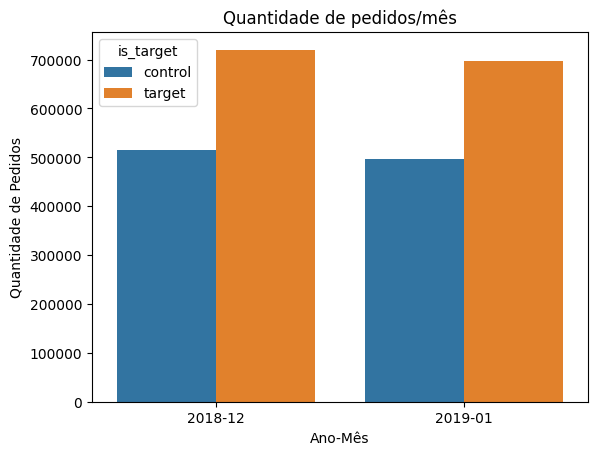

In [33]:
sns.barplot(data=df_grouped_monthly, x='year_month', y='total_orders', hue='is_target')
plt.title('Quantidade de pedidos/mês')
plt.xlabel('Ano-Mês')
plt.ylabel('Quantidade de Pedidos');

In [34]:
qtd_pedidos_12_2018_control = df_grouped_monthly[(df_grouped_monthly['year_month'] == '2018-12') & (df_grouped_monthly['is_target'] == 'control')]['total_orders'].values[0]
qtd_pedidos_12_2018_target = df_grouped_monthly[(df_grouped_monthly['year_month'] == '2018-12') & (df_grouped_monthly['is_target'] == 'target')]['total_orders'].values[0]
qtd_pedidos_01_2019_control = df_grouped_monthly[(df_grouped_monthly['year_month'] == '2019-01') & (df_grouped_monthly['is_target'] == 'control')]['total_orders'].values[0]
qtd_pedidos_01_2019_target = df_grouped_monthly[(df_grouped_monthly['year_month'] == '2019-01') & (df_grouped_monthly['is_target'] == 'target')]['total_orders'].values[0]

diff_pedidos_target_control_12_2018 = qtd_pedidos_12_2018_target - qtd_pedidos_12_2018_control
diff_pedidos_target_control_01_2019 = qtd_pedidos_01_2019_target - qtd_pedidos_01_2019_control
diff_pedidos_control = qtd_pedidos_01_2019_control - qtd_pedidos_12_2018_control
diff_pedidos_target = qtd_pedidos_01_2019_target - qtd_pedidos_12_2018_target
pct_pedidos_target_control_12_2018 = round((((qtd_pedidos_12_2018_target / qtd_pedidos_12_2018_control) - 1) * 100), 2)
pct_pedidos_target_control_01_2019 = round((((qtd_pedidos_01_2019_target / qtd_pedidos_01_2019_control) - 1) * 100), 2)
pct_pedidos_control = round((((qtd_pedidos_01_2019_control / qtd_pedidos_12_2018_control) - 1) * 100), 2)
pct_pedidos_target = round((((qtd_pedidos_01_2019_target / qtd_pedidos_12_2018_target) - 1) * 100), 2)

print(f"A diferença em quantidade de pedidos entre os meses de Dez/18 e Jan/19 para o grupo control foi de: {diff_pedidos_control}")
print(f"A diferença em percentual de pedidos entre os meses de Dez/18 e Jan/19 para o grupo control foi de: {pct_pedidos_control}%")
print(f"A diferença em quantidade de pedidos entre os meses de Dez/18 e Jan/19 para o grupo target foi de: {diff_pedidos_target}")
print(f"A diferença em percentual de pedidos entre os meses de Dez/18 e Jan/19 para o grupo target foi de: {pct_pedidos_target}%")
print("\n")
print(f"A diferença em quantidade de pedidos entre os grupos target e control em Dez/18 foi de: {diff_pedidos_target_control_12_2018}")
print(f"A diferença em percentual de pedidos entre os grupos target e control em Dez/18 foi de: {pct_pedidos_target_control_12_2018}%")
print(f"A diferença em quantidade de pedidos entre os grupos target e control em Jan/19 foi de: {diff_pedidos_target_control_01_2019}")
print(f"A diferença em percentual de pedidos entre os grupos target e control em Jan/19 foi de: {pct_pedidos_target_control_01_2019}%")

A diferença em quantidade de pedidos entre os meses de Dez/18 e Jan/19 para o grupo control foi de: -18938
A diferença em percentual de pedidos entre os meses de Dez/18 e Jan/19 para o grupo control foi de: -3.68%
A diferença em quantidade de pedidos entre os meses de Dez/18 e Jan/19 para o grupo target foi de: -23459
A diferença em percentual de pedidos entre os meses de Dez/18 e Jan/19 para o grupo target foi de: -3.26%


A diferença em quantidade de pedidos entre os grupos target e control em Dez/18 foi de: 205230
A diferença em percentual de pedidos entre os grupos target e control em Dez/18 foi de: 39.86%
A diferença em quantidade de pedidos entre os grupos target e control em Jan/19 foi de: 200709
A diferença em percentual de pedidos entre os grupos target e control em Jan/19 foi de: 40.47%


Houveram diferenças na quantidade de pedidos efetuados entre os meses de dez/2018 e jan/19.

Nota-se decréscimo no número de pedidos tanto para os grupos de controle como target.

**Analisando o faturamento**

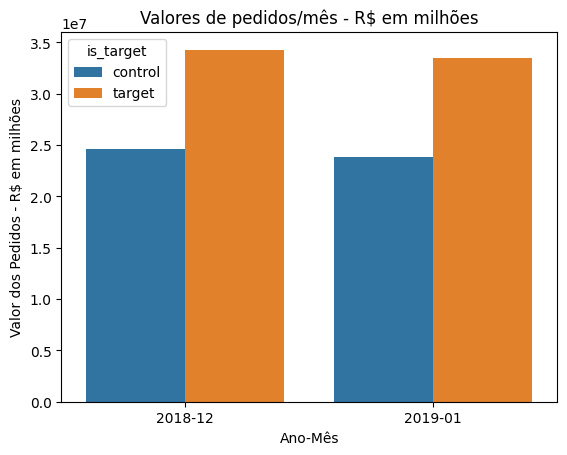

In [35]:
sns.barplot(data=df_grouped_monthly, x='year_month', y='total_amount', hue='is_target')
plt.title('Valores de pedidos/mês - R$ em milhões')
plt.xlabel('Ano-Mês')
plt.ylabel('Valor dos Pedidos - R$ em milhões');

In [36]:
vlr_pedidos_12_2018_control = df_grouped_monthly[(df_grouped_monthly['year_month'] == '2018-12') & (df_grouped_monthly['is_target'] == 'control')]['total_amount'].values[0]
vlr_pedidos_12_2018_target = df_grouped_monthly[(df_grouped_monthly['year_month'] == '2018-12') & (df_grouped_monthly['is_target'] == 'target')]['total_amount'].values[0]
vlr_pedidos_01_2019_control = df_grouped_monthly[(df_grouped_monthly['year_month'] == '2019-01') & (df_grouped_monthly['is_target'] == 'control')]['total_amount'].values[0]
vlr_pedidos_01_2019_target = df_grouped_monthly[(df_grouped_monthly['year_month'] == '2019-01') & (df_grouped_monthly['is_target'] == 'target')]['total_amount'].values[0]

diff_vlr_target_control_12_2018 = vlr_pedidos_12_2018_target - vlr_pedidos_12_2018_control
diff_vlr_pedidos_target_control_01_2019 = vlr_pedidos_01_2019_target - vlr_pedidos_01_2019_control
diff_vlr_pedidos_control = vlr_pedidos_01_2019_control - vlr_pedidos_12_2018_control
diff_vlr_pedidos_target = vlr_pedidos_01_2019_target - vlr_pedidos_12_2018_target
pct_vlr_pedidos_target_control_12_2018 = round((((vlr_pedidos_12_2018_target / vlr_pedidos_12_2018_control) - 1) * 100), 2)
pct_vlr_pedidos_target_control_01_2019 = round((((vlr_pedidos_01_2019_target / vlr_pedidos_01_2019_control) - 1) * 100), 2)
pct_vlr_pedidos_control = round((((vlr_pedidos_01_2019_control / vlr_pedidos_12_2018_control) - 1) * 100), 2)
pct_vlr_pedidos_target = round((((vlr_pedidos_01_2019_target / vlr_pedidos_12_2018_target) - 1) * 100), 2)

print(f"A diferença em valor de pedidos entre os meses de Dez/18 e Jan/19 para o grupo control foi de: R$ {diff_vlr_pedidos_control:,.2f}")
print(f"A diferença em percentual de valor de pedidos entre os meses de Dez/18 e Jan/19 para o grupo control foi de: {pct_vlr_pedidos_control}%")
print(f"A diferença em valor de pedidos entre os meses de Dez/18 e Jan/19 para o grupo target foi de: R$ {diff_vlr_pedidos_target:,.2f}")
print(f"A diferença em percentual de valor de pedidos entre os meses de Dez/18 e Jan/19 para o grupo target foi de: {pct_vlr_pedidos_target}%")
print("\n")
print(f"A diferença em valor de pedidos entre os grupos target e control em Dez/18 foi de: R$ {diff_vlr_target_control_12_2018:,.2f}")
print(f"A diferença em percentual de valor de pedidos entre os grupos target e control em Dez/18 foi de: {pct_vlr_pedidos_target_control_12_2018}%")
print(f"A diferença em valor de pedidos entre os grupos target e control em Jan/19 foi de: R$ {diff_vlr_pedidos_target_control_01_2019:,.2f}")
print(f"A diferença em percentual de valor de pedidos entre os grupos target e control em Jan/19 foi de: {pct_vlr_pedidos_target_control_01_2019}%")

A diferença em valor de pedidos entre os meses de Dez/18 e Jan/19 para o grupo control foi de: R$ -847,135.29
A diferença em percentual de valor de pedidos entre os meses de Dez/18 e Jan/19 para o grupo control foi de: -3.44%
A diferença em valor de pedidos entre os meses de Dez/18 e Jan/19 para o grupo target foi de: R$ -825,180.33
A diferença em percentual de valor de pedidos entre os meses de Dez/18 e Jan/19 para o grupo target foi de: -2.41%


A diferença em valor de pedidos entre os grupos target e control em Dez/18 foi de: R$ 9,637,914.00
A diferença em percentual de valor de pedidos entre os grupos target e control em Dez/18 foi de: 39.12%
A diferença em valor de pedidos entre os grupos target e control em Jan/19 foi de: R$ 9,659,868.96
A diferença em percentual de valor de pedidos entre os grupos target e control em Jan/19 foi de: 40.6%


Houveram diferenças no valor de pedidos efetuados entre os meses de dez/2018 e jan/19.

Nota-se declínio no valor total de pedidos tanto para os grupos de controle como target, mas o grupo target manteve percentual positivo próximo entre os meses em relação ao grupo de controle.

Analisando usuários distintos ativos - usuários que tiveram ao menos um pedido feito no mês.

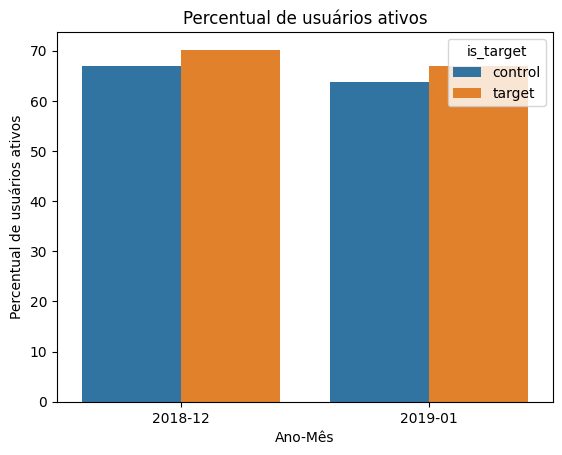

In [37]:
sns.barplot(data=df_grouped_monthly, x='year_month', y='percentage_distinct_customers_orders_vs_ab_test', hue='is_target')
plt.title('Percentual de usuários ativos')
plt.xlabel('Ano-Mês')
plt.ylabel('Percentual de usuários ativos');

In [38]:
pct_usuarios_ativos_12_2018_control = df_grouped_monthly[(df_grouped_monthly['year_month'] == '2018-12') & (df_grouped_monthly['is_target'] == 'control')]['percentage_distinct_customers_orders_vs_ab_test'].values[0]
pct_usuarios_ativos_12_2018_target = df_grouped_monthly[(df_grouped_monthly['year_month'] == '2018-12') & (df_grouped_monthly['is_target'] == 'target')]['percentage_distinct_customers_orders_vs_ab_test'].values[0]
pct_usuarios_ativos_01_2019_control = df_grouped_monthly[(df_grouped_monthly['year_month'] == '2019-01') & (df_grouped_monthly['is_target'] == 'control')]['percentage_distinct_customers_orders_vs_ab_test'].values[0]
pct_usuarios_ativos_01_2019_target = df_grouped_monthly[(df_grouped_monthly['year_month'] == '2019-01') & (df_grouped_monthly['is_target'] == 'target')]['percentage_distinct_customers_orders_vs_ab_test'].values[0]

diff_pct_usuarios_ativos_target_control_12_2018 = round((pct_usuarios_ativos_12_2018_target - pct_usuarios_ativos_12_2018_control), 2)
diff_pct_usuarios_ativos_target_control_01_2019 = round((pct_usuarios_ativos_01_2019_target - pct_usuarios_ativos_01_2019_control), 2)
diff_pct_usuarios_ativos_control = round((pct_usuarios_ativos_01_2019_control - pct_usuarios_ativos_12_2018_control), 2)
diff_pct_usuarios_ativos_target = round((pct_usuarios_ativos_01_2019_target - pct_usuarios_ativos_12_2018_target), 2)

print(f"A diferença em percentual de usuários ativos entre os meses de Dez/18 e Jan/19 para o grupo control foi de: {diff_pct_usuarios_ativos_control}p.p")
print(f"A diferença em percentual de usuários ativos entre os meses de Dez/18 e Jan/19 para o grupo target foi de: {diff_pct_usuarios_ativos_target}p.p")
print("\n")
print(f"A diferença em percentual de usuários ativos entre os grupos target e control em Dez/18 foi de: {diff_pct_usuarios_ativos_target_control_12_2018}")
print(f"A diferença em percentual de usuários ativos entre os grupos target e control em Jan/19 foi de: {diff_pct_usuarios_ativos_target_control_01_2019}")

A diferença em percentual de usuários ativos entre os meses de Dez/18 e Jan/19 para o grupo control foi de: -3.25p.p
A diferença em percentual de usuários ativos entre os meses de Dez/18 e Jan/19 para o grupo target foi de: -3.19p.p


A diferença em percentual de usuários ativos entre os grupos target e control em Dez/18 foi de: 3.21
A diferença em percentual de usuários ativos entre os grupos target e control em Jan/19 foi de: 3.26


**Podemos concluir inicialmente que:**
- Tanto em quantidade de pedidos quanto em valores, o **grupo target teve maior presença e expressividade** do que o grupo control.
-- O grupo **target teve 405.939 (40%) pedidos a mais** do que o grupo control e em termos **financeiros trouxe mais de R$ 19 milhões (39,84%) a mais** do que o grupo control. Logo, podemos concluir inicialmente que o cupom teve **influência financeira** no resultado da campanha.

- Em termos de **usuários ativos, ou seja, usuários que fizeram ao menos um pedido no período analisado** tivemos ambos os grupos presentes, considerando que:
-- Ambos os grupos tiveram o percentual de usuários ativos (usuários com ao menos 01 pedido feito no período analisado) próximo (entre 65 a 70%).
-- 100% dos usuários do grupo **target** tiveram ao menos um pedido realizado no período analisado.

#### 4.3.1. - Definindo indicadores relevantes para mensurar sucesso da campanha e se houve impacto significativo

Inicialmente foi analisado em termos de segregação por mês e grupo de controle e target qual foi o resultado geral e vimos que houve resultado positivo do grupo target em relação ao grupo de controle. Porém vamos aprofundar nas análises afim de validar se houve impacto positivo na retenção de usuários dentro da plataforma.

Para isso, teremos alguns indicadores que serão gerados para validarmos a retenção de usuários:

- Taxa de retenção: usuários que voltaram a realizar pedido nos dias seguintes após realização do primeiro pedido;
- Número médio de pedidos por usuário;
    - Testes Estatísticos;
- Ticket Médio por Usuário e Life Time Value LTV;

##### 4.3.1.1. - Taxa de retenção

Taxa de retenção será o indicador que apresentará a proporção de usuários que fizeram um **novo pedido após a primeira interação** dentro de um determinado período de tempo.

In [39]:
# Lista de quantidade de dias para mensurar
dias_para_retencao = [1, 5, 10, 15, 20, 25, 30, 45, 60]

# Criando uma copia da base geral
df_taxa_retencao = df_geral.copy()

# Passo 1: pegar a data do primeiro pedido por usuário
df_first_order = df_geral.groupby('customer_id')['order_created_at'].min().reset_index()
df_first_order.columns = ['customer_id', 'first_order_date']

# Passo 2: unir com todos os pedidos
df_taxa_retencao = df_geral.merge(df_first_order, on='customer_id')

# Passo 3: calcular diferença entre o pedido atual e o primeiro
df_taxa_retencao['dias_depois'] = (df_taxa_retencao['order_created_at'] - df_taxa_retencao['first_order_date']).dt.days

for i in dias_para_retencao:

  # Passo 4: considerar retido quem fez outro pedido em até X dias
  df_retidos = df_taxa_retencao[(df_taxa_retencao['dias_depois'] > 0) & (df_taxa_retencao['dias_depois'] <= i)]
  usuarios_retidos = df_retidos['customer_id'].unique()

  df_retidos_control = df_taxa_retencao[(df_taxa_retencao['dias_depois'] > 0) & (df_taxa_retencao['dias_depois'] <= i) & (df_taxa_retencao['is_target'] == 'control')]
  usuarios_retidos_control = df_retidos_control['customer_id'].unique()

  df_retidos_target = df_taxa_retencao[(df_taxa_retencao['dias_depois'] > 0) & (df_taxa_retencao['dias_depois'] <= i) & (df_taxa_retencao['is_target'] == 'target')]
  usuarios_retidos_target = df_retidos_target['customer_id'].unique()

  # Passo 5: calcular taxa
  total_usuarios = df_taxa_retencao['customer_id'].nunique()
  total_usuarios_target = df_taxa_retencao[df_taxa_retencao['is_target'] == 'target']['customer_id'].nunique()
  total_usuarios_control = df_taxa_retencao[df_taxa_retencao['is_target'] == 'control']['customer_id'].nunique()
  retidos = len(usuarios_retidos)
  retidos_target = len(usuarios_retidos_target)
  retidos_control = len(usuarios_retidos_control)
  taxa_retencao = retidos / total_usuarios * 100
  taxa_retencao_control = retidos_control / total_usuarios_control * 100
  taxa_retencao_target = retidos_target / total_usuarios_target * 100

  print(f"Taxa de retenção ({i} dias): {taxa_retencao:.2f}%")
  print(f"Taxa de retenção control ({i} dias): {taxa_retencao_control:.2f}%")
  print(f"Taxa de retenção target ({i} dias): {taxa_retencao_target:.2f}%")
  print("\n")

Taxa de retenção (1 dias): 5.66%
Taxa de retenção control (1 dias): 5.05%
Taxa de retenção target (1 dias): 6.15%


Taxa de retenção (5 dias): 18.48%
Taxa de retenção control (5 dias): 16.58%
Taxa de retenção target (5 dias): 20.02%


Taxa de retenção (10 dias): 29.07%
Taxa de retenção control (10 dias): 26.06%
Taxa de retenção target (10 dias): 31.49%


Taxa de retenção (15 dias): 35.48%
Taxa de retenção control (15 dias): 31.83%
Taxa de retenção target (15 dias): 38.43%


Taxa de retenção (20 dias): 39.71%
Taxa de retenção control (20 dias): 35.62%
Taxa de retenção target (20 dias): 43.03%


Taxa de retenção (25 dias): 43.08%
Taxa de retenção control (25 dias): 38.62%
Taxa de retenção target (25 dias): 46.68%


Taxa de retenção (30 dias): 45.31%
Taxa de retenção control (30 dias): 40.62%
Taxa de retenção target (30 dias): 49.11%


Taxa de retenção (45 dias): 49.77%
Taxa de retenção control (45 dias): 44.57%
Taxa de retenção target (45 dias): 53.97%


Taxa de retenção (60 dias): 51.01

**Na análise dos resultados temos:**
- A campanha teve impacto **positivo crescente até o 60º dia**, especialmente entre os dias 10 e 60;
- Maior expressão a partir de 20 dias onde o grupo target teve mais de 40% de retenção;
- A **diferença média** de retenção entre target e controle foi de **~5 a 8 pontos percentuais**, sendo que a partir de 30 dias teve um salto médio de 10 pontos percentuais.


In [40]:
qtd_pedidos_por_usuario = df_geral.groupby(['customer_id', 'is_target'])['order_id'].count().reset_index().rename(columns={'order_id': 'count'})
perc = [0.01, 0.05, 0.1, 0.15, 0.25, 0.35, 0.45, 0.5, 0.65, 0.75, 0.85, 0.95, 0.99]
qtd_pedidos_por_usuario.describe(percentiles=perc)


,count
count,806466.000000
mean,3.009941
std,3.747375
min,1.000000
1%,1.000000
5%,1.000000
10%,1.000000
15%,1.000000
25%,1.000000
35%,1.000000


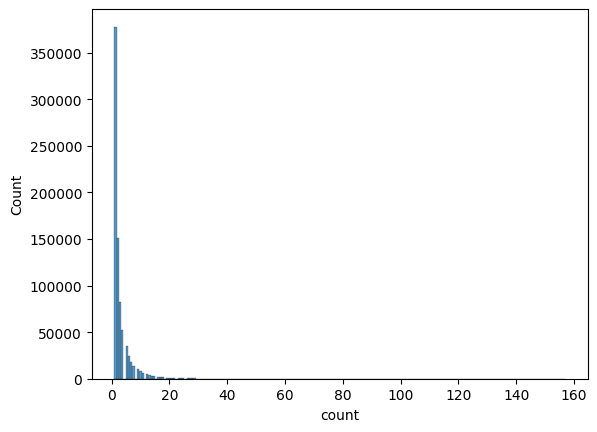

In [41]:
sns.histplot(data = qtd_pedidos_por_usuario, x = 'count', bins=200);

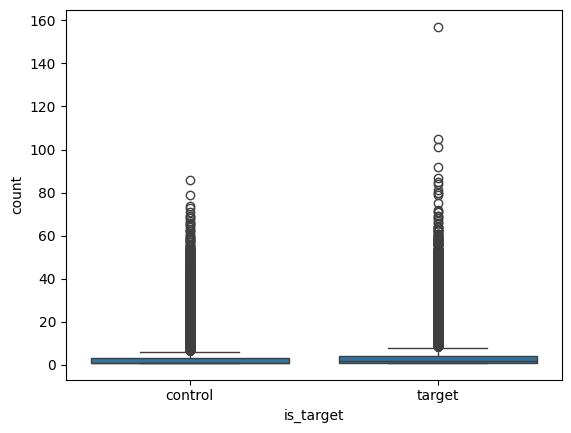

In [42]:
sns.boxplot(data = qtd_pedidos_por_usuario, x='is_target', y = 'count');

##### 4.3.1.2. - Número médio de pedidos por usuário

Número médio de pedidos por usuário fará a **medição do engajamento médio dos usuários com a plataforma**. Relação do **total de pedidos com o total de usuários distintos**.

In [43]:
# Total de pedidos
total_pedidos = df_geral['order_id'].nunique()

# Total de usuários
total_usuarios = df_geral['customer_id'].nunique()

# Número médio de pedidos por usuário
media_pedidos = total_pedidos / total_usuarios

print(f"Número médio de pedidos por usuário: {media_pedidos:.2f}")

Número médio de pedidos por usuário: 3.02


In [44]:
df_media_por_grupo = (
    df_geral
    .groupby('is_target')
    .agg(
        total_pedidos=('order_id', 'nunique'),
        total_usuarios=('customer_id', 'nunique')
    )
    .assign(media_pedidos_por_usuario=lambda x: x['total_pedidos'] / x['total_usuarios'])
    .reset_index()
)

df_media_por_grupo

,is_target,total_pedidos,total_usuarios,media_pedidos_por_usuario
0,control,1010738,360542,2.803385
1,target,1416677,445924,3.176947


Grupo **target** com maior média de pedidos

In [45]:
# Agrupa por customer_id e is_target para contar os pedidos de cada cliente
df_pedidos_por_usuario = (
    df_geral
    .groupby(['customer_id', 'is_target'])['order_id']
    .count()
    .reset_index(name='num_pedidos')
)

# Estatísticas descritivas por grupo is_target
df_estatisticas = (
    df_pedidos_por_usuario
    .groupby('is_target')['num_pedidos']
    .agg(
        media_pedidos='mean',
        desvio_padrao='std',
        variancia='var',
        mediana='median',
        min='min',
        max='max',
        total_usuarios='count'
    )
    .reset_index()
)

df_estatisticas

,is_target,media_pedidos,desvio_padrao,variancia,mediana,min,max,total_usuarios
0,control,2.803385,3.592769,12.907986,1.0,1,86,360542
1,target,3.176947,3.859793,14.898005,2.0,1,157,445924


###### Testes estatísticos

In [46]:
from scipy.stats import ttest_ind

# Separa os dois grupos
grupo_control = df_pedidos_por_usuario[df_pedidos_por_usuario['is_target'] == 'control']['num_pedidos']
grupo_teste = df_pedidos_por_usuario[df_pedidos_por_usuario['is_target'] == 'target']['num_pedidos']

# Realiza o t-teste para médias independentes
t_stat, p_valor = ttest_ind(grupo_teste, grupo_control, equal_var=False)  # Welch’s t-test

print(f'Estatística t: {t_stat:.10f}')
print(f'p-valor: {p_valor:.20f}')

Estatística t: 44.9030410834
p-valor: 0.00000000000000000000


Estatística t = 44 indicando que há variação entre os grupos
p-valor < 0.05 indicando que a variação da média não é fruto do acaso - de fato temos maior volume de pedidos sendo realizado pelo grupo **target**

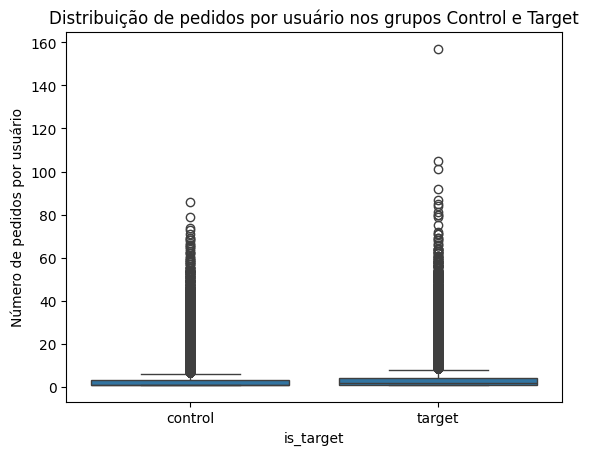

In [47]:
sns.boxplot(data=df_pedidos_por_usuario, x='is_target', y='num_pedidos')
plt.title('Distribuição de pedidos por usuário nos grupos Control e Target')
plt.xlabel('is_target')
plt.ylabel('Número de pedidos por usuário')
plt.show()

/tmp/ipython-input-49-3730508009.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(grupo_control, label='Controle', shade=True)
/tmp/ipython-input-49-3730508009.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(grupo_teste, label='Tratamento', shade=True)


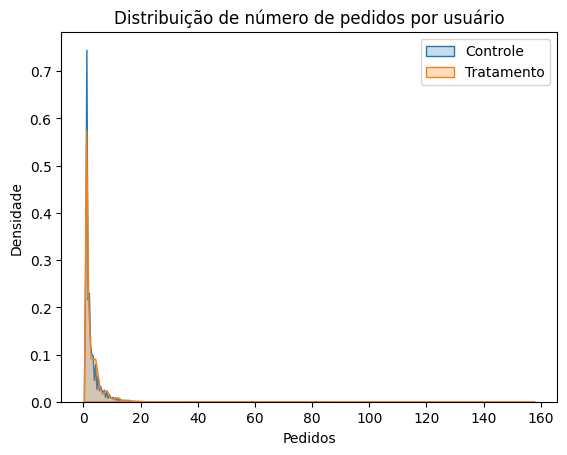

In [49]:
sns.kdeplot(grupo_control, label='Controle', shade=True)
sns.kdeplot(grupo_teste, label='Tratamento', shade=True)
plt.title('Distribuição de número de pedidos por usuário')
plt.xlabel('Pedidos')
plt.ylabel('Densidade')
plt.legend()
plt.show()

##### 4.3.1.3 - Life Time Value LTV

Life Time Value fará a medição da expectativa de faturamento que o negócio espera receber por consumidor ao longo da sua relação na plataforma

In [50]:
df_ltv = (
    df_geral
    .groupby(['is_target'])
    .agg(
        ticket_medio=('order_total_amount', 'mean'),
        pedidos_por_usuario=('order_id', 'count')
    )
    .reset_index()
)

# Para normalizar por usuário (se tiver repetições)
df_usuarios = df_geral.groupby(['is_target'])['customer_id'].nunique().reset_index(name='total_usuarios')
df_ltv = df_ltv.merge(df_usuarios, on=['is_target'], how='left')
df_ltv['pedidos_por_usuario'] /= df_ltv['total_usuarios']

df_ltv['ltv'] = df_ltv['ticket_medio'] * df_ltv['pedidos_por_usuario']
print(df_ltv[['is_target', 'ltv']])

  is_target         ltv
0   control  134.331655
1    target  151.886838


In [51]:
df_ticket_medio = (
    df_geral
    .groupby('is_target')
    .agg(
        receita_total=('order_total_amount', 'sum'),
        total_pedidos=('order_id', 'nunique')
    )
    .assign(ticket_medio=lambda x: x['receita_total'] / x['total_pedidos'])
    .reset_index()
)
print(df_ticket_medio)

  is_target  receita_total  total_pedidos  ticket_medio
0   control    48432203.49        1010738     47.917664
1    target    67729986.45        1416677     47.809053


In [53]:
def analisar_segmento(df, coluna_segmento):
    df_resultado = (
        df.groupby([coluna_segmento, 'is_target'])
        .agg(
            receita_total=('order_total_amount', 'sum'),
            total_pedidos=('order_id', 'nunique'),
            total_usuarios=('customer_id', 'nunique')
        )
        .assign(
            ticket_medio=lambda x: x['receita_total'] / x['total_pedidos'],
            pedidos_por_usuario=lambda x: x['total_pedidos'] / x['total_usuarios'],
            ltv=lambda x: x['receita_total'] / x['total_usuarios']
        )
        .reset_index()
    )

    return df_resultado

In [54]:
df_estado = analisar_segmento(df_geral, 'delivery_address_state')
df_plataforma = analisar_segmento(df_geral, 'origin_platform')
df_faixa_preco = analisar_segmento(df_geral, 'restaurant_price_range')
df_ticket_medio_rest = analisar_segmento(df_geral, 'restaurant_average_ticket')

In [55]:
print(df_estado)

   delivery_address_state is_target  receita_total  total_pedidos  \
0                      AC   control          10.00              1   
1                      AC    target          59.00              1   
2                      AL   control      191455.39           4647   
3                      AL    target      269125.22           6802   
4                      AM   control      567998.14          12693   
5                      AM    target      772174.61          17227   
6                      BA   control     1345612.70          26281   
7                      BA    target     1834290.22          36138   
8                      CE   control     1864340.02          47255   
9                      CE    target     2650203.53          67075   
10                     DF   control     1572400.39          35293   
11                     DF    target     2238929.09          50049   
12                     ES   control      879754.76          22315   
13                     ES    targe

In [56]:
print(df_plataforma)

  origin_platform is_target  receita_total  total_pedidos  total_usuarios  \
0         ANDROID   control    17593567.22         404960          160257   
1         ANDROID    target    24445157.43         568153          199259   
2         DESKTOP   control     6987718.83         150882           60764   
3         DESKTOP    target     9813375.87         211649           75870   
4             IOS   control    23532702.19         446861          154441   
5             IOS    target    33039330.75         626170          193998   
6   WINDOWS_PHONE   control      318115.25           8033            3604   
7   WINDOWS_PHONE    target      432122.40          10705            4524   

   ticket_medio  pedidos_por_usuario         ltv  
0     43.445198             2.526941  109.783455  
1     43.025659             2.851329  122.680318  
2     46.312475             2.483082  114.997677  
3     46.366276             2.789627  129.344614  
4     52.662242             2.893409  152.373412  


In [57]:
print(df_faixa_preco)

   restaurant_price_range is_target  receita_total  total_pedidos  \
0                       1   control     7050976.74         201119   
1                       1    target     9888206.36         283289   
2                       2   control     7629522.62         202933   
3                       2    target    10671500.03         283542   
4                       3   control    18746005.15         388027   
5                       3    target    26133344.33         542452   
6                       4   control     9693339.34         159929   
7                       4    target    13400841.28         223521   
8                       5   control     5312359.64          58730   
9                       5    target     7636094.45          83873   

   total_usuarios  ticket_medio  pedidos_por_usuario         ltv  
0          107465     35.058730             1.871484   65.611843  
1          143543     34.905013             1.973548   68.886719  
2          111800     37.596264        

In [58]:
print(df_ticket_medio_rest)

    restaurant_average_ticket is_target  receita_total  total_pedidos  \
0                         0.0   control         660.00             14   
1                         0.0    target        1378.50             22   
2                        16.0   control        1035.00             43   
3                        16.0    target        1367.00             57   
4                        25.0   control          41.50              3   
5                        25.0    target         118.00              5   
6                        30.0   control     6417891.16         188390   
7                        30.0    target     9040251.36         265960   
8                        35.0   control        1598.50             35   
9                        35.0    target        3451.00             67   
10                       40.0   control     7276458.87         201314   
11                       40.0    target    10177014.21         281396   
12                       59.0   control         149

#### 4.3.2. - Análises Comportamentais

Agora a análise será feita baseado no padrão de comportamento ao decorrer do tempo. Para trazermos os resultados em termos qualitativos de performance da campanha.

Para isso, teremos alguns indicadores que serão gerados para acompanhar a performance:

- Taxa de retenção: usuários que voltaram a realizar pedido nos dias seguintes após realização do primeiro pedido;
- Número médio de pedidos por usuário;
    - Testes Estatísticos;
- Ticket Médio por Usuário e Life Time Value LTV;

In [59]:
# Cria coluna com o número da semana (ano + semana)
df_geral['year_week'] = df_geral['order_created_at'].dt.strftime('%Y-%U')  # %U = semana do ano

# Agrega os dados por semana e grupo
df_semanal = (
    df_geral
    .groupby(['year_week', 'is_target'])
    .agg(
        total_pedidos=('order_id', 'nunique'),
        receita_total=('order_total_amount', 'sum'),
        total_usuarios=('customer_id', 'nunique')
    )
    .reset_index()
)

# Calcula métricas derivadas
df_semanal['ticket_medio'] = df_semanal['receita_total'] / df_semanal['total_pedidos']
df_semanal['pedidos_por_usuario'] = df_semanal['total_pedidos'] / df_semanal['total_usuarios']
df_semanal['ltv_semanal'] = df_semanal['receita_total'] / df_semanal['total_usuarios']

# Ordena as semanas corretamente
df_semanal = df_semanal.sort_values(by=['year_week', 'is_target']).reset_index(drop=True)

df_semanal.head()
print(df_semanal.head())

,year_week,is_target,total_pedidos,receita_total,total_usuarios,ticket_medio,pedidos_por_usuario,ltv_semanal
0,2018-48,control,91251,4195908.84,68920,45.982059,1.324013,60.880860
1,2018-48,target,129549,5944996.76,95879,45.889947,1.351172,62.005202
2,2018-49,control,132842,6537808.10,97184,49.214918,1.366912,67.272474
3,2018-49,target,186105,9147584.91,132533,49.152816,1.404216,69.021186
4,2018-50,control,120954,5700385.14,88171,47.128538,1.371812,64.651474


In [63]:
print(df_semanal)

   year_week is_target  total_pedidos  receita_total  total_usuarios  \
0    2018-48   control          91251     4195908.84           68920   
1    2018-48    target         129549     5944996.76           95879   
2    2018-49   control         132842     6537808.10           97184   
3    2018-49    target         186105     9147584.91          132533   
4    2018-50   control         120954     5700385.14           88171   
5    2018-50    target         169444     8007515.99          120881   
6    2018-51   control         122515     5880282.47           89278   
7    2018-51    target         169970     7983892.11          121337   
8    2018-52   control          47276     2325284.84           42414   
9    2018-52    target          65000     3193593.62           57673   
10   2019-00   control          76451     3830507.64           61618   
11   2019-00    target         105656     5225112.43           82926   
12   2019-01   control         105306     4982731.26           7

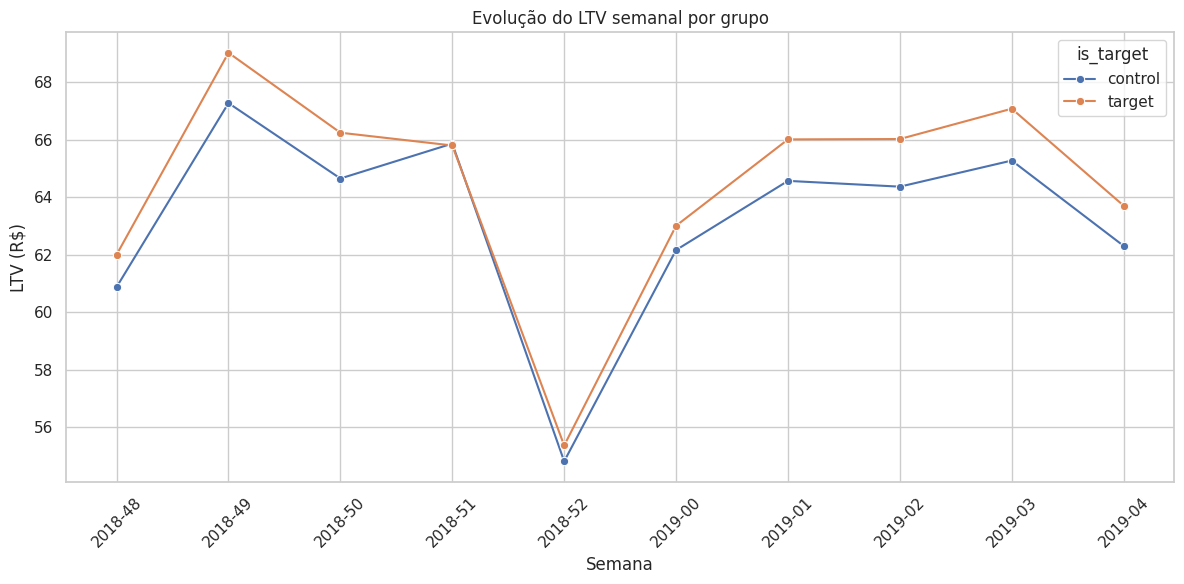

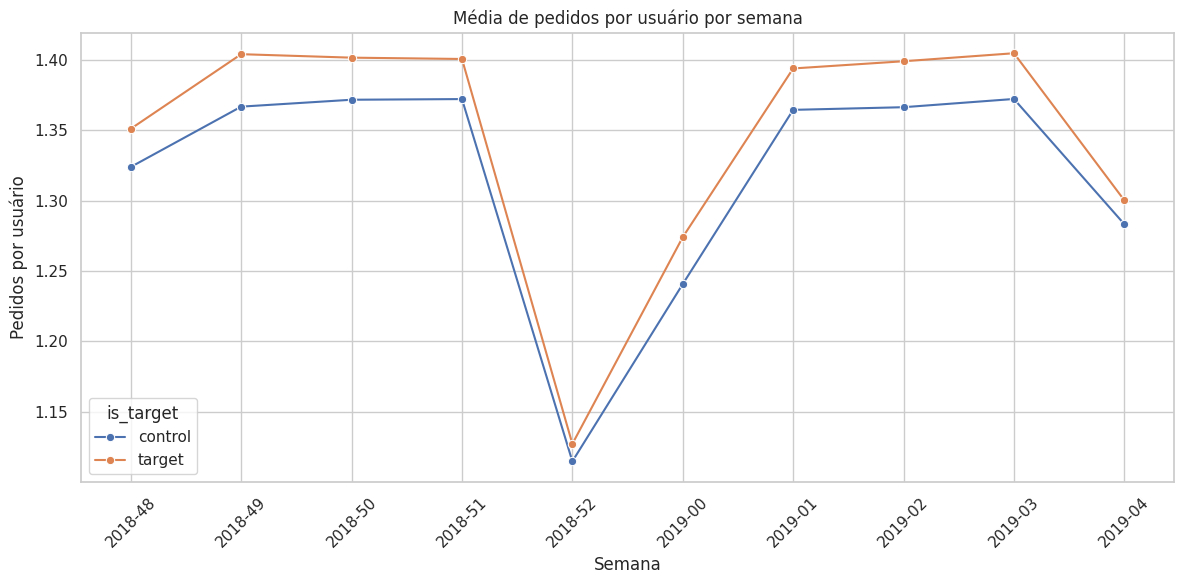

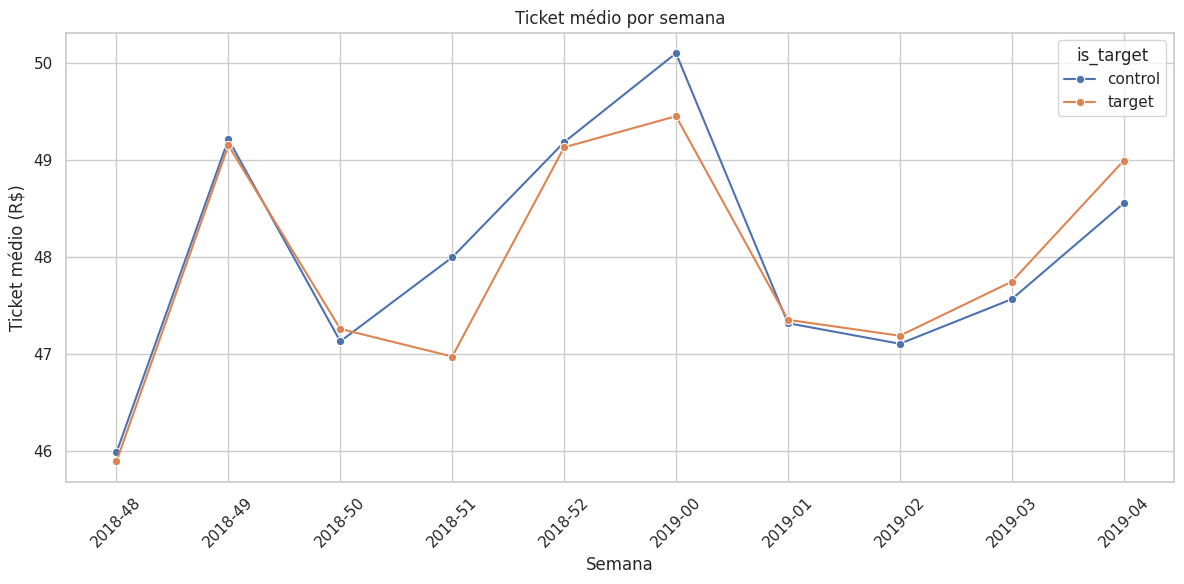

In [68]:
# Define estilo
sns.set(style="whitegrid")

# Plot 1 – LTV semanal
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_semanal, x='year_week', y='ltv_semanal', hue='is_target', marker='o')
plt.title('Evolução do LTV semanal por grupo')
plt.xlabel('Semana')
plt.ylabel('LTV (R$)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 2 – Pedidos por usuário
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_semanal, x='year_week', y='pedidos_por_usuario', hue='is_target', marker='o')
plt.title('Média de pedidos por usuário por semana')
plt.xlabel('Semana')
plt.ylabel('Pedidos por usuário')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 3 – Ticket médio
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_semanal, x='year_week', y='ticket_medio', hue='is_target', marker='o')
plt.title('Ticket médio por semana')
plt.xlabel('Semana')
plt.ylabel('Ticket médio (R$)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [62]:
df_semanal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year_week            20 non-null     object 
 1   is_target            20 non-null     object 
 2   total_pedidos        20 non-null     int64  
 3   receita_total        20 non-null     float64
 4   total_usuarios       20 non-null     int64  
 5   ticket_medio         20 non-null     float64
 6   pedidos_por_usuario  20 non-null     float64
 7   ltv_semanal          20 non-null     float64
dtypes: float64(4), int64(2), object(2)
memory usage: 1.4+ KB


In [64]:
# Cria um pivot para facilitar comparação
pivot = df_semanal.pivot(index='year_week', columns='is_target', values='ltv_semanal').reset_index()
pivot['delta_ltv_pct'] = ((pivot['target'] - pivot['control']) / pivot['control']) * 100

pivot[['year_week', 'control', 'target', 'delta_ltv_pct']]

is_target,year_week,control,target,delta_ltv_pct
0,2018-48,60.880860,62.005202,1.846791
1,2018-49,67.272474,69.021186,2.599447
2,2018-50,64.651474,66.242966,2.461648
3,2018-51,65.864854,65.799320,-0.099498
4,2018-52,54.823521,55.374155,1.004374
5,2019-00,62.165400,63.009339,1.357569
6,2019-01,64.569079,66.010351,2.232139
7,2019-02,64.367820,66.023340,2.571969
8,2019-03,65.275280,67.077118,2.760367
9,2019-04,62.308971,63.706839,2.243446


In [65]:
# Cria um pivot para facilitar comparação
pivot = df_semanal.pivot(index='year_week', columns='is_target', values='ltv_semanal').reset_index()
pivot['delta_ltv_pct'] = ((pivot['target'] - pivot['control']) / pivot['control']) * 100

print(pivot[['year_week', 'control', 'target', 'delta_ltv_pct']])

is_target year_week    control     target  delta_ltv_pct
0           2018-48  60.880860  62.005202       1.846791
1           2018-49  67.272474  69.021186       2.599447
2           2018-50  64.651474  66.242966       2.461648
3           2018-51  65.864854  65.799320      -0.099498
4           2018-52  54.823521  55.374155       1.004374
5           2019-00  62.165400  63.009339       1.357569
6           2019-01  64.569079  66.010351       2.232139
7           2019-02  64.367820  66.023340       2.571969
8           2019-03  65.275280  67.077118       2.760367
9           2019-04  62.308971  63.706839       2.243446


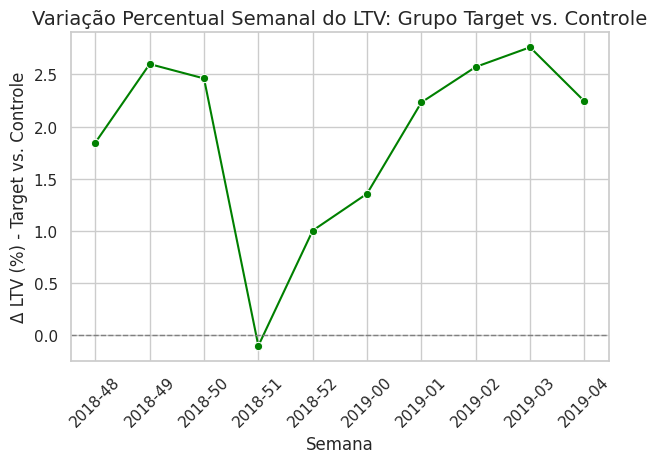

In [66]:
# Plot do delta percentual
sns.lineplot(data=pivot, x='year_week', y='delta_ltv_pct', marker='o', color='green')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Título e rótulos
plt.title('Variação Percentual Semanal do LTV: Grupo Target vs. Controle', fontsize=14)
plt.xlabel('Semana')
plt.ylabel('Δ LTV (%) - Target vs. Controle')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

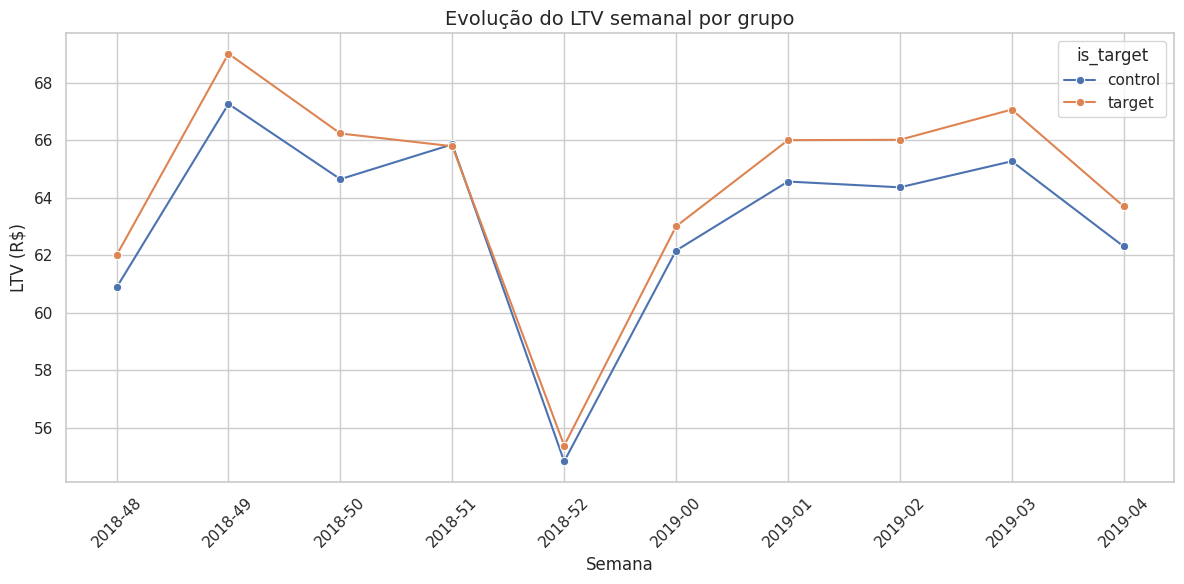

In [67]:
# LTV Absoluto por grupo ao longo do tempo
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_semanal, x='year_week', y='ltv_semanal', hue='is_target', marker='o')
plt.title('Evolução do LTV semanal por grupo', fontsize=14)
plt.xlabel('Semana')
plt.ylabel('LTV (R$)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Valor do cupom: R$ 1.0


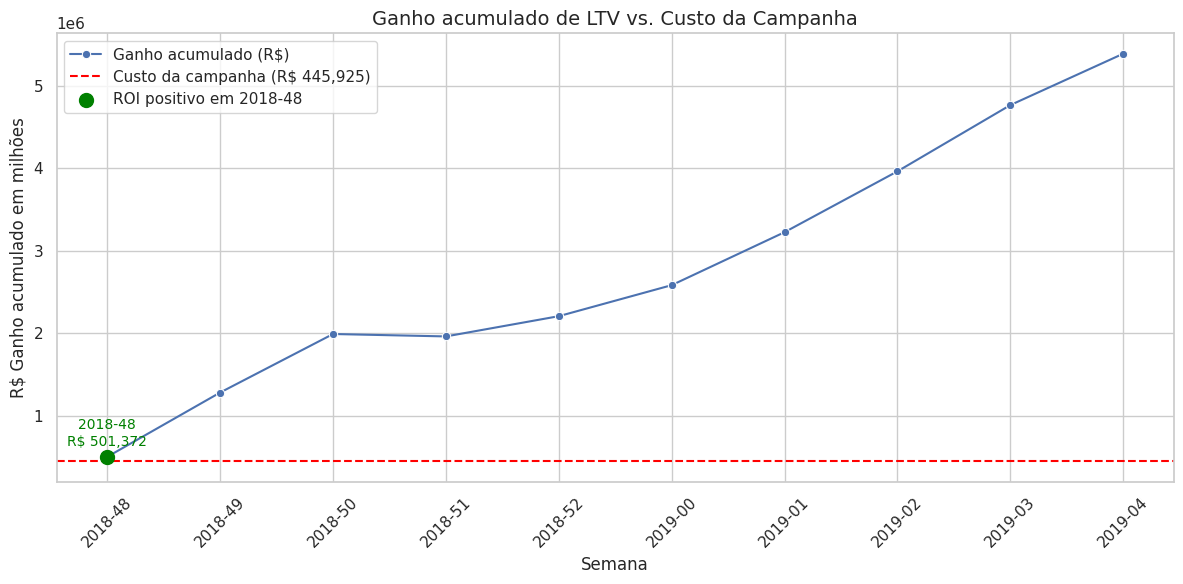

Valor do cupom: R$ 2.0


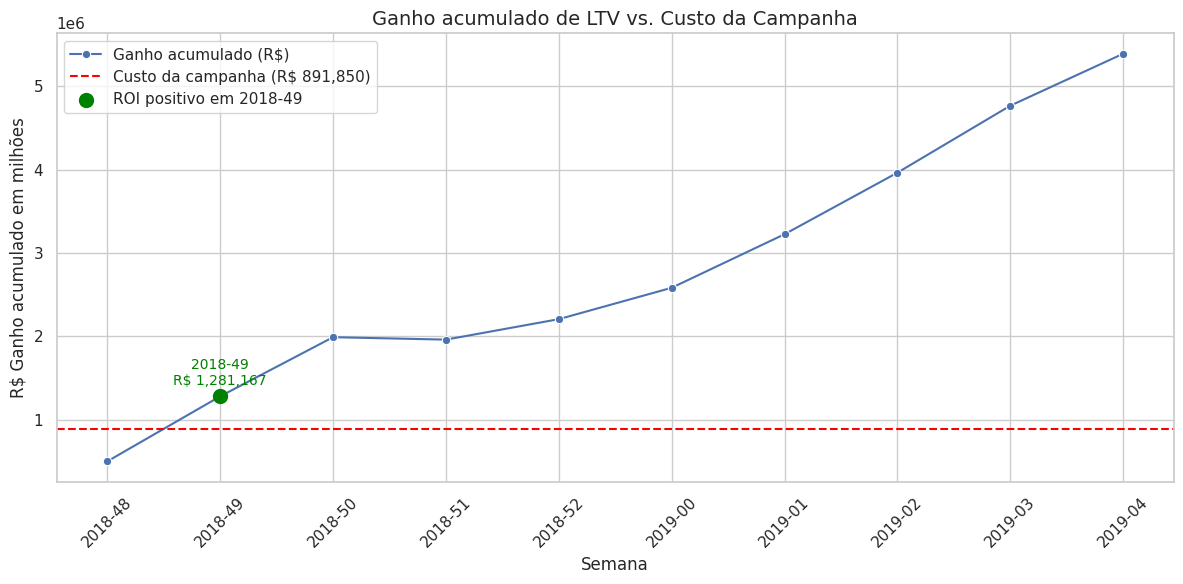

Valor do cupom: R$ 5.0


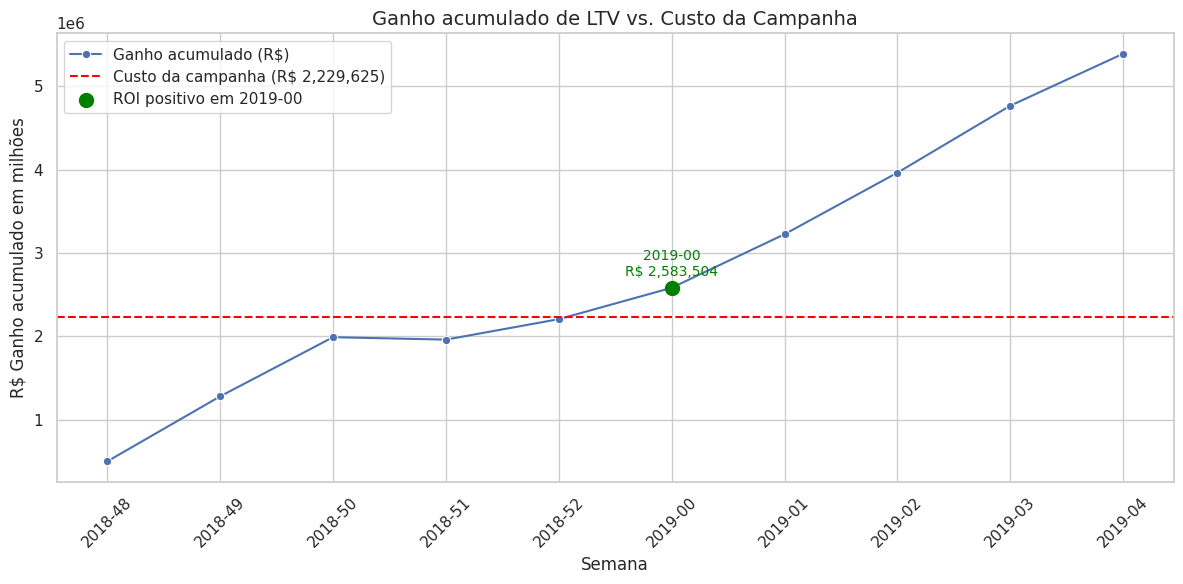

Valor do cupom: R$ 7.0


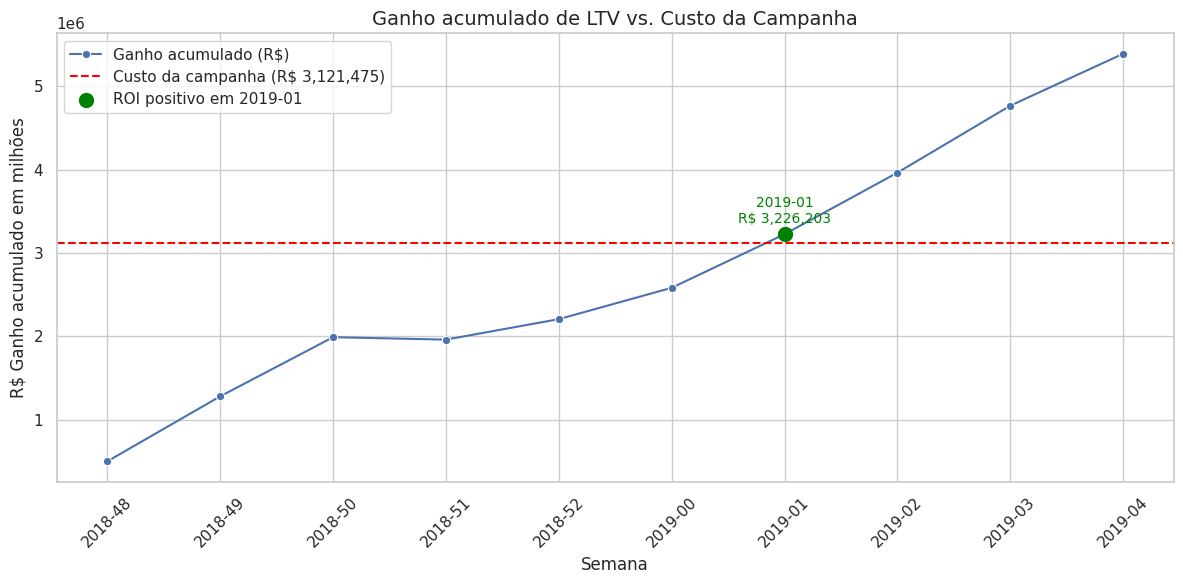

Valor do cupom: R$ 10.0


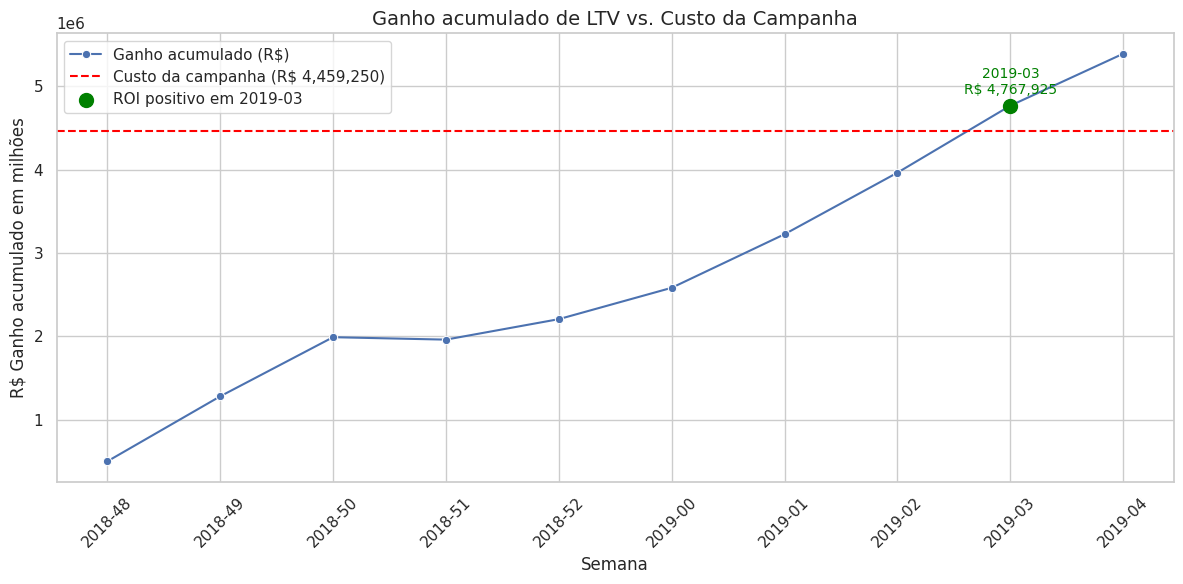

Valor do cupom: R$ 12.0


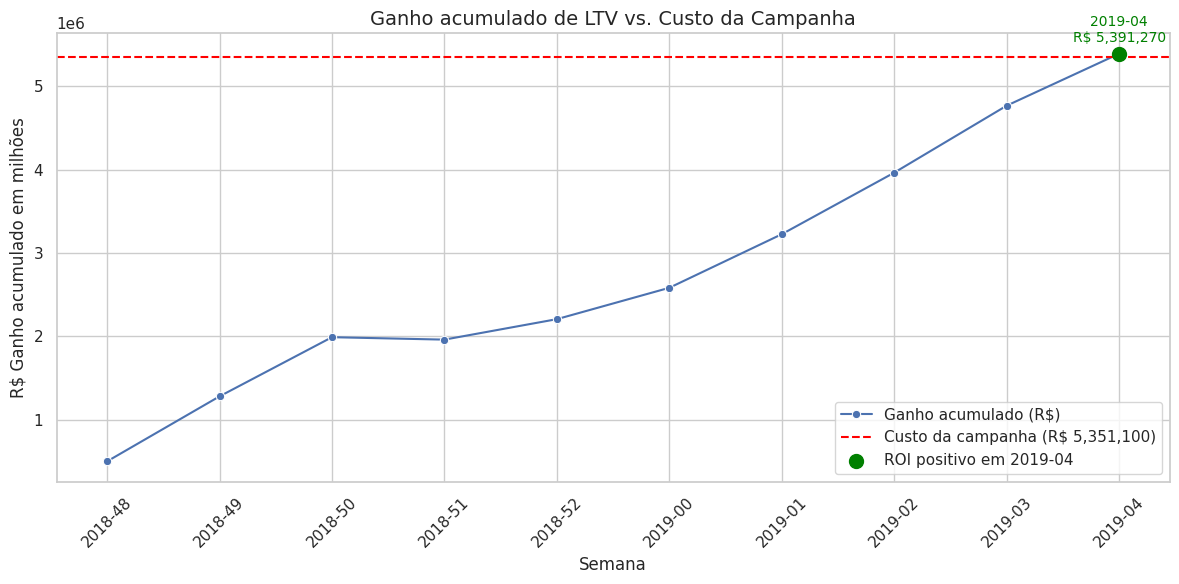

⚠️ Nenhuma semana atingiu ROI positivo com os dados atuais.
Valor do cupom: R$ 15.0


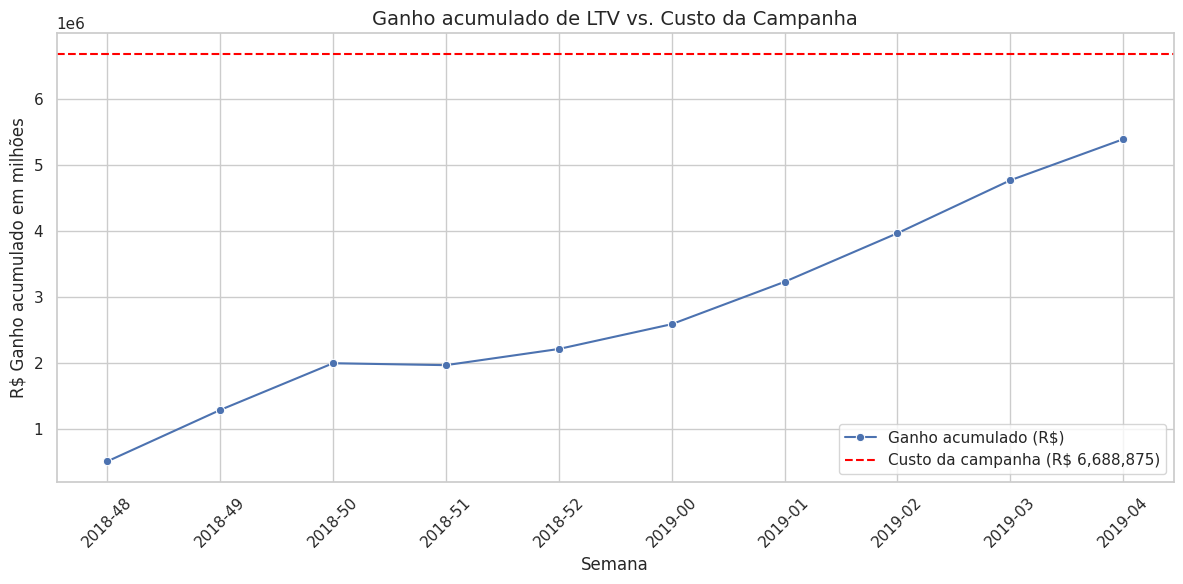

In [111]:
valores_cupom = [1.0, 2.0, 5.0, 7.0, 10.0, 12.0, 15.0]

for i in valores_cupom:

  custo_total_campanha = i * 1 * 445925
  pivot['ganho_ltv_total_semana'] = (pivot['target'] - pivot['control']) * total_usuarios_target
  pivot['ganho_acumulado'] = pivot['ganho_ltv_total_semana'].cumsum()
  pivot['roi_positivo'] = pivot['ganho_acumulado'] > custo_total_campanha
  semana_roi_positivo = pivot[pivot['roi_positivo']].head(1)

  # Estilo
  sns.set(style="whitegrid")
  plt.figure(figsize=(12, 6))

  # Linha do ganho acumulado
  sns.lineplot(data=pivot, x="year_week", y="ganho_acumulado", label="Ganho acumulado (R$)", marker="o")

  # Linha horizontal do custo
  plt.axhline(y=custo_total_campanha, color='red', linestyle='--', label=f'Custo da campanha (R$ {custo_total_campanha:,.0f})')

  # Verifica se existe ponto de ROI positivo
  semana_roi_positivo = pivot[pivot['ganho_acumulado'] > custo_total_campanha]

  if not semana_roi_positivo.empty:
      roi_week = semana_roi_positivo['year_week'].iloc[0]
      roi_value = semana_roi_positivo['ganho_acumulado'].iloc[0]

      plt.scatter(roi_week, roi_value, color='green', s=100, zorder=5, label=f'ROI positivo em {roi_week}')
      plt.text(roi_week, roi_value + 100000, f"{roi_week}\nR$ {roi_value:,.0f}",
              ha='center', va='bottom', fontsize=10, color='green')
  else:
      print("⚠️ Nenhuma semana atingiu ROI positivo com os dados atuais.")

  print(f"Valor do cupom: R$ {i}")
  # Ajustes finais
  plt.title("Ganho acumulado de LTV vs. Custo da Campanha", fontsize=14)
  plt.xlabel("Semana")
  plt.ylabel("R$ Ganho acumulado em milhões")
  plt.xticks(rotation=45)
  plt.legend()
  plt.tight_layout()
  plt.show()